In [1]:
import tensorflow as tf
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

In [2]:
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn

from tensorflow import keras
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras import backend as K
from tensorflow.python.client import device_lib

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix

from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_objective, plot_evaluations
from skopt import gp_minimize

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

print(f"Python {sys.version}")
print()
print(f"Pandas {pd.__version__}")
print(f"Tensorflow {tf.__version__}")
print(f"Keras {keras.__version__}")
print(f"SciKit Learn {sklearn.__version__}")
print()

devices = device_lib.list_local_devices()

if 'GPU' in ('').join(str(devices)):
    print("tf accessable GPU found: "+devices[-2].physical_device_desc)

/home/siderealyear/anaconda3/envs/tensorflow-gpu/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/siderealyear/anaconda3/envs/tensorflow-gpu/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Python 3.7.7 (default, Mar 23 2020, 22:36:06) 
[GCC 7.3.0]

Pandas 1.0.3
Tensorflow 2.1.0
Keras 2.2.4-tf
SciKit Learn 0.22.1

tf accessable GPU found: device: 0, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1


In [3]:
import plotting_functions
import data_functions

In [4]:
def one_sample_density_plot(
    plot_location, 
    data, 
    #normalized_data, 
    data_type, 
    title, 
    xlabel, 
    ylabel, 
):
    values, base = np.histogram(data[data_type], bins=40)

    ax[plot_location].plot(base[:-1], (values/len(data)))
    ax[plot_location].tick_params(labelsize=12)
    ax[plot_location].set_title(title, fontsize=18)
    ax[plot_location].set_xlabel(xlabel, fontsize=14)
    ax[plot_location].set_ylabel(ylabel, fontsize=15)
    ax[plot_location].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

def three_sample_density_plot(
    plot_location, 
    sample_1_data,
    sample_2_data,
    sample_3_data,
    data_type, 
    title, 
    xlabel, 
    ylabel, 
):
    sample_1_values, sample_1_base = np.histogram(sample_1_data[data_type], bins=40)
    sample_2_values, sample_2_base = np.histogram(sample_2_data[data_type], bins=40)
    sample_3_values, sample_3_base = np.histogram(sample_3_data[data_type], bins=40)

    ax[plot_location].plot(sample_1_base[:-1], (sample_1_values/len(sample_1_data)))
    ax[plot_location].plot(sample_2_base[:-1], (sample_2_values/len(sample_2_data)))
    ax[plot_location].plot(sample_3_base[:-1], (sample_3_values/len(sample_1_data)))
    ax[plot_location].tick_params(labelsize=12)
    ax[plot_location].set_title(title, fontsize=18)
    ax[plot_location].set_xlabel(xlabel, fontsize=14)
    ax[plot_location].set_ylabel(ylabel, fontsize=15)
    ax[plot_location].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


In [5]:
data_file = '/mnt/SSD/data/training_data/1992-2015_california_features_added.parquet'

# Features to use during training 
features = [
    'lat',
    'lon',
    'mean_air_2m',
    'mean_apcp',
    'mean_rhum_2m',
    'mean_dpt_2m',
    'mean_pres_sfc',
    'mean_uwnd_10m',
    'mean_vwnd_10m',
#     'mean_vis',
    'mean_cloud_cover',
    'max_air_2m',
#     'max_apcp',
#     'max_rhum_2m',
#     'max_dpt_2m',
#     'max_pres_sfc',
#     'max_uwnd_10m',
#     'max_vwnd_10m',
#     'max_vis',
#     'max_cloud_cover',
    'min_air_2m',
#     'min_apcp',
#     'min_rhum_2m',
#     'min_dpt_2m',
#     'min_pres_sfc',
#     'min_uwnd_10m',
#     'min_vwnd_10m',
#     'min_vis',
#     'min_cloud_cover',
    'veg',
    'crain',
    'ignition',
#     'total_fires',
    'date'
]

features_to_scale = [
    'mean_air_2m',
    'mean_apcp',
    'mean_rhum_2m',
    'mean_dpt_2m',
    'mean_pres_sfc',
    'mean_uwnd_10m',
    'mean_vwnd_10m',
#     'mean_vis',
    'mean_cloud_cover',
    'max_air_2m',
#     'max_apcp',
#     'max_rhum_2m',
#     'max_dpt_2m',
#     'max_pres_sfc',
#     'max_uwnd_10m',
#     'max_vwnd_10m',
#     'max_vis',
#     'max_cloud_cover',
    'min_air_2m',
#     'min_apcp',
#     'min_rhum_2m',
#     'min_dpt_2m',
#     'min_pres_sfc',
#     'min_uwnd_10m',
#     'min_vwnd_10m',
#     'min_vis',
#     'min_cloud_cover',
#     'total_fires'
      'veg',
      'crain'
]

month_dtypes = {
    'January':    'float32',
    'February':   'float32',
    'March':      'float32',
    'April':      'float32',
    'May':        'float32',
    'June':       'float32',
    'July':       'float32',
    'August':     'float32',
    'September':  'float32',
    'October':    'float32',
    'November':   'float32',
    'December':   'float32'
}

In [6]:
# Load data
raw_data = pd.read_parquet(data_file)

# Pull out columns of intrest
data = raw_data[features]

# Pick one spatial bin with fires
data = data[(data['lat'] == 39.42233) & (data['lon'] == -120.6546)]

num_fires = data['ignition'].sum()
total_observations = len(data)

print("Num fires: "+str(num_fires))
print("Total obervations: "+str(total_observations))

# convert ignition to int
data['ignition'] = data['ignition'].astype('int')

# Also drop lat, lon, columns (unnecessary)
data.drop(['lat', 'lon'], axis=1, inplace=True)

data.reset_index(inplace=True, drop=True)
data.head()

Num fires: 716.0
Total obervations: 8766


,mean_air_2m,mean_apcp,mean_rhum_2m,mean_dpt_2m,mean_pres_sfc,mean_uwnd_10m,mean_vwnd_10m,mean_cloud_cover,max_air_2m,min_air_2m,veg,crain,ignition,date
0,272.066956,0.000000,54.349842,263.759735,82468.335938,-2.419784,3.027377,1.625000,278.654724,269.370331,70.699997,0.000,0,1992-01-01
1,273.152374,0.000343,46.536934,262.851501,82450.710938,-1.904384,3.347039,1.880208,278.771637,270.165314,70.699997,0.000,0,1992-01-02
2,274.637451,0.020557,43.627312,263.381226,81925.929688,-1.495060,1.557715,13.437500,279.329834,271.714264,70.699997,0.000,0,1992-01-03
3,273.870850,0.898149,73.530479,269.089813,81348.601562,1.027952,6.304882,50.510418,275.773804,272.108826,70.699997,0.000,0,1992-01-04
4,273.817963,2.706949,93.832382,272.896027,81021.375000,1.164567,11.754253,66.333336,274.953461,272.592834,70.699997,0.125,0,1992-01-05


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8766 entries, 0 to 8765
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   mean_air_2m       8766 non-null   float32       
 1   mean_apcp         8766 non-null   float32       
 2   mean_rhum_2m      8766 non-null   float32       
 3   mean_dpt_2m       8766 non-null   float32       
 4   mean_pres_sfc     8766 non-null   float32       
 5   mean_uwnd_10m     8766 non-null   float32       
 6   mean_vwnd_10m     8766 non-null   float32       
 7   mean_cloud_cover  8766 non-null   float32       
 8   max_air_2m        8766 non-null   float32       
 9   min_air_2m        8766 non-null   float32       
 10  veg               8766 non-null   float32       
 11  crain             8766 non-null   float32       
 12  ignition          8766 non-null   int64         
 13  date              8766 non-null   datetime64[ns]
dtypes: datetime64[ns](1), fl

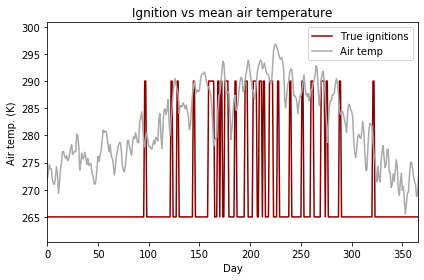

In [8]:
plotting_functions.data_diagnostic_plot(data, 'mean_air_2m', 25, 265)

In [9]:
onehot_encoder = OneHotEncoder(sparse=False)

# Training data
month = np.array(pd.DatetimeIndex(data['date']).month).reshape(-1, 1)
month = month.astype('int')
onehot_month = onehot_encoder.fit_transform(month).astype('int32')
onehot_month_df = pd.DataFrame(onehot_month, columns = month_dtypes.keys())
onehot_month_df.reset_index(drop = True, inplace = True)
onehot_month_df = onehot_month_df.astype('int')
data.reset_index(drop = True, inplace = True)
data = pd.concat([data, onehot_month_df], axis = 1)
data.drop('date', axis = 1, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8766 entries, 0 to 8765
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mean_air_2m       8766 non-null   float32
 1   mean_apcp         8766 non-null   float32
 2   mean_rhum_2m      8766 non-null   float32
 3   mean_dpt_2m       8766 non-null   float32
 4   mean_pres_sfc     8766 non-null   float32
 5   mean_uwnd_10m     8766 non-null   float32
 6   mean_vwnd_10m     8766 non-null   float32
 7   mean_cloud_cover  8766 non-null   float32
 8   max_air_2m        8766 non-null   float32
 9   min_air_2m        8766 non-null   float32
 10  veg               8766 non-null   float32
 11  crain             8766 non-null   float32
 12  ignition          8766 non-null   int64  
 13  January           8766 non-null   int64  
 14  February          8766 non-null   int64  
 15  March             8766 non-null   int64  
 16  April             8766 non-null   int64  


KeyError: 'max_air_2m'

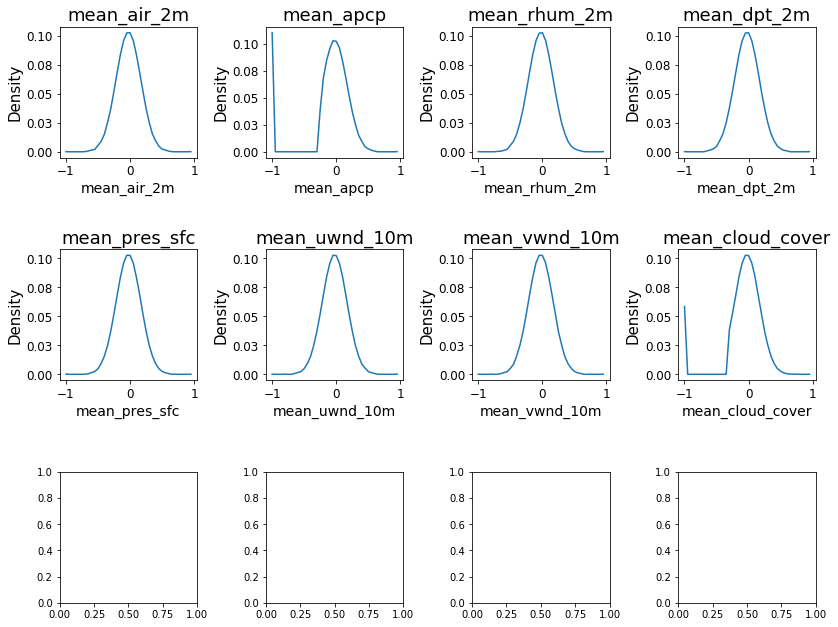

In [29]:
# Distribution plotting variables

left  = 0.125  # the left side of the subplots of the figure
right = 0.65   # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.5   # the amount of width reserved for blank space between subplots
hspace = 0.7   # the amount of height reserved for white space between subplots

fig_rows = 3
fig_cols = 4
plot_height = 10
plot_width = 20

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
#     (3,0),(3,1),(3,2),(3,3),
#     (4,0),(4,1),(4,2),(4,3),
#     (5,0),(5,1),(5,2),(5,3),
#     (6,0),(6,1),(6,2)
]

data_types = [
    'mean_air_2m',
    'mean_apcp',
    'mean_rhum_2m',
    'mean_dpt_2m',
    'mean_pres_sfc',
    'mean_uwnd_10m',
    'mean_vwnd_10m',
#     'mean_vis',
    'mean_cloud_cover',
    'max_air_2m',
#     'max_apcp',
#     'max_rhum_2m',
#     'max_dpt_2m',
#     'max_pres_sfc',
#     'max_uwnd_10m',
#     'max_vwnd_10m',
#     'max_vis',
#     'max_cloud_cover',
    'min_air_2m',
#     'min_apcp',
#     'min_rhum_2m',
#     'min_dpt_2m',
#     'min_pres_sfc',
#     'min_uwnd_10m',
#     'min_vwnd_10m',
#     'min_vis',
#     'min_cloud_cover',
#     'total_fires',
      'veg',
      'crain'
]

xlabels = data_types
ylabels = ['Density'] * len(data_types)

# Make density plots
fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(plot_locations)):
    ax[plot_locations[i]] = one_sample_density_plot(plot_locations[i], data, data_types[i], data_types[i], data_types[i], ylabels[i])

In [11]:
qt = QuantileTransformer(random_state = 0, output_distribution = 'normal')
normalized_data = pd.DataFrame(qt.fit_transform(data[features_to_scale]), columns=features_to_scale)
data[features_to_scale] = normalized_data

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_features = scaler.fit_transform(data[features_to_scale])
data[features_to_scale] = scaled_features

data[features_to_scale] = data[features_to_scale].astype('float32')

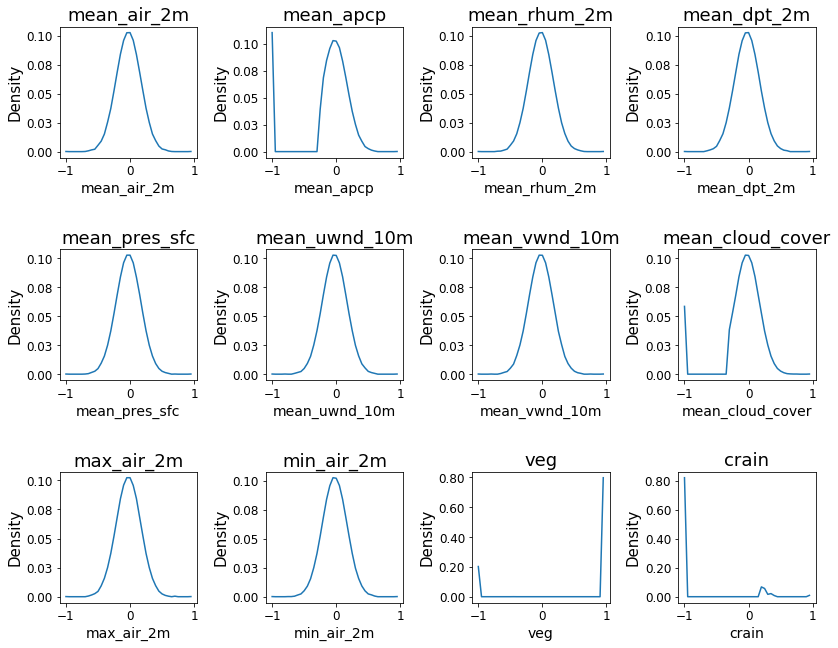

In [12]:
# Distribution plotting variables

left  = 0.125  # the left side of the subplots of the figure
right = 0.65   # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.5   # the amount of width reserved for blank space between subplots
hspace = 0.7   # the amount of height reserved for white space between subplots

fig_rows = 3
fig_cols = 4
plot_height = 10
plot_width = 20

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
#     (3,0),(3,1),(3,2),(3,3),
#     (4,0),(4,1),(4,2),(4,3),
#     (5,0),(5,1),(5,2),(5,3),
#     (6,0),(6,1),(6,2)
]

data_types = [
    'mean_air_2m',
    'mean_apcp',
    'mean_rhum_2m',
    'mean_dpt_2m',
    'mean_pres_sfc',
    'mean_uwnd_10m',
    'mean_vwnd_10m',
#     'mean_vis',
    'mean_cloud_cover',
    'max_air_2m',
#     'max_apcp',
#     'max_rhum_2m',
#     'max_dpt_2m',
#     'max_pres_sfc',
#     'max_uwnd_10m',
#     'max_vwnd_10m',
#     'max_vis',
#     'max_cloud_cover',
    'min_air_2m',
#     'min_apcp',
#     'min_rhum_2m',
#     'min_dpt_2m',
#     'min_pres_sfc',
#     'min_uwnd_10m',
#     'min_vwnd_10m',
#     'min_vis',
#     'min_cloud_cover',
      'veg',
      'crain'
#     'total_fires'
]

xlabels = data_types
ylabels = ['Density'] * len(data_types)

# Make density plots
fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(plot_locations)):
    ax[plot_locations[i]] = one_sample_density_plot(plot_locations[i], data, data_types[i], data_types[i], data_types[i], ylabels[i])
    
plt.show()

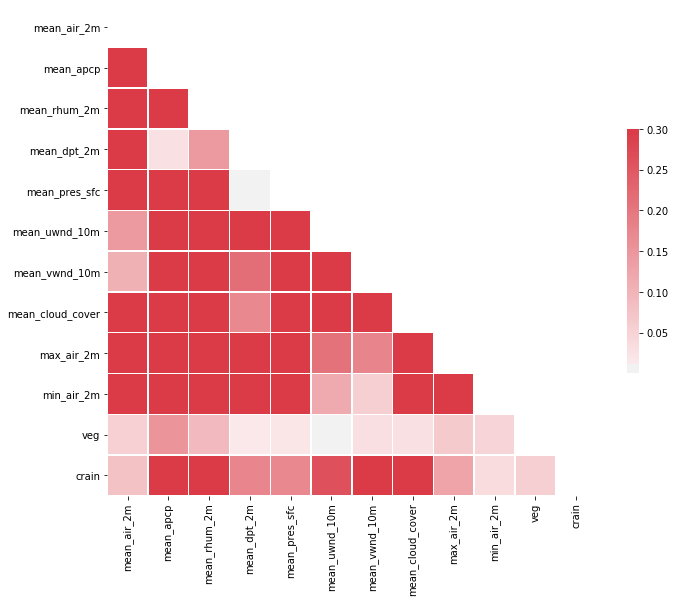

In [13]:
corr = data[features_to_scale].corr().abs()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [14]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [15]:
to_drop

['max_air_2m', 'min_air_2m']

In [16]:
data = data.drop(data[to_drop], axis=1)

In [17]:
# Split data up into training, testing and validation sets
test_data = data.tail(int(len(data)*0.25))
leftover_data = data.head(int(len(data)*0.75))
validation_data = data.tail(int(len(leftover_data)*0.5))
training_data = data.head(int(len(leftover_data)*0.5))

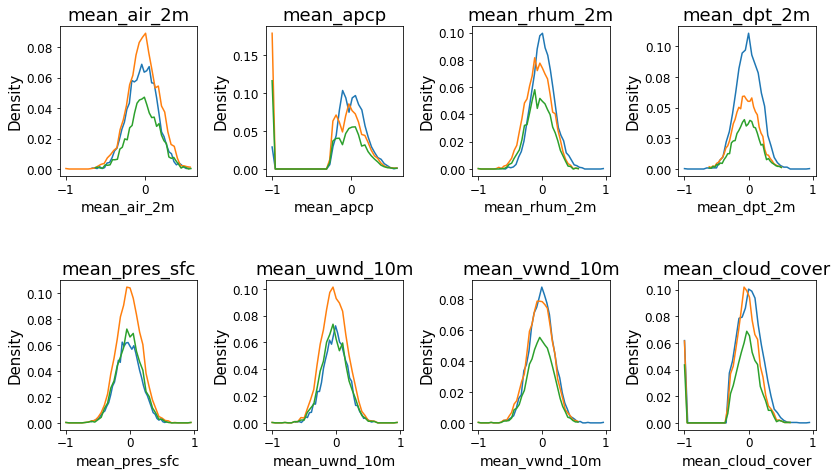

In [18]:
# Distribution plotting variables

left  = 0.125  # the left side of the subplots of the figure
right = 0.65   # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.5   # the amount of width reserved for blank space between subplots
hspace = 0.7   # the amount of height reserved for white space between subplots

fig_rows = 2
fig_cols = 4
plot_height = 7
plot_width = 20

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
#    (2,0),(2,1),(2,2),(2,3),
#     (3,0),(3,1),(3,2),(3,3),
#     (4,0),(4,1),(4,2),(4,3),
#     (5,0),(5,1),(5,2),(5,3),
#     (6,0),(6,1),(6,2)
]

data_types = [
    'mean_air_2m',
    'mean_apcp',
    'mean_rhum_2m',
    'mean_dpt_2m',
    'mean_pres_sfc',
    'mean_uwnd_10m',
    'mean_vwnd_10m',
#     'mean_vis',
    'mean_cloud_cover',
#     'max_air_2m',
#     'max_apcp',
#     'max_rhum_2m',
#     'max_dpt_2m',
#     'max_pres_sfc',
#     'max_uwnd_10m',
#     'max_vwnd_10m',
#     'max_vis',
#     'max_cloud_cover',
#     'min_air_2m',
#     'min_apcp',
#     'min_rhum_2m',
#     'min_dpt_2m',
#     'min_pres_sfc',
#     'min_uwnd_10m',
#     'min_vwnd_10m',
#     'min_vis',
#     'min_cloud_cover',
#     'total_fires'
]

# reshaped_training_data = training_data.reshape(training_data.shape[1], training_data.shape[0])
# reshaped_validation_data = validation_data.reshape(validation_data.shape[1], validation_data.shape[0])
# reshaped_test_data = test_data.reshape(test_data.shape[1], test_data.shape[0])

xlabels = data_types
ylabels = ['Density'] * len(data_types)

# Make density plots
fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(plot_locations)):
    ax[plot_locations[i]] = three_sample_density_plot(
        plot_locations[i], 
        training_data, 
        validation_data, 
        test_data, 
        data_types[i], 
        data_types[i], 
        data_types[i], 
        ylabels[i]
    )
    
plt.show()

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8766 entries, 0 to 8765
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mean_air_2m       8766 non-null   float32
 1   mean_apcp         8766 non-null   float32
 2   mean_rhum_2m      8766 non-null   float32
 3   mean_dpt_2m       8766 non-null   float32
 4   mean_pres_sfc     8766 non-null   float32
 5   mean_uwnd_10m     8766 non-null   float32
 6   mean_vwnd_10m     8766 non-null   float32
 7   mean_cloud_cover  8766 non-null   float32
 8   veg               8766 non-null   float32
 9   crain             8766 non-null   float32
 10  ignition          8766 non-null   int64  
 11  January           8766 non-null   int64  
 12  February          8766 non-null   int64  
 13  March             8766 non-null   int64  
 14  April             8766 non-null   int64  
 15  May               8766 non-null   int64  
 16  June              8766 non-null   int64  


In [20]:
# Convert to numpy arrays
training_data = np.array(training_data)
training_labels = training_data[:, -13]
training_data = np.delete(training_data, -13, 1)

validation_data = np.array(validation_data)
validation_labels = validation_data[:, -13]
validation_data = np.delete(validation_data, -13, 1)

test_data = np.array(test_data)
test_labels = test_data[:, -13]
test_data = np.delete(test_data, -13, 1)

In [21]:
print(type(training_data))
print(type(validation_data))
print(type(test_data))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### First, let's try and over fit the crap out of it with a 100 unit LSTM. We will use Gaussian process minimization to optimize the learning rate, past history and class weights. Loss function is binary cross entropy. Minimization and early stopping will use Matthews correlation coefficient.

In [26]:
future_target = 1
step = 1
past_history = 5

raw_output_bias = np.log([num_fires/(total_observations - num_fires)])
output_bias = tf.keras.initializers.Constant(raw_output_bias)

EPOCHS = 50

path_best_model = './trained_models/first_round_skopt_single_statefull_LTSM_CA_only.keras'
best_matthews_correlation = -1.0

metrics = [
    keras.metrics.TruePositives(name='true_positives'),
    keras.metrics.FalsePositives(name='false_positives'),
    keras.metrics.TrueNegatives(name='true_negatives'),
    keras.metrics.FalseNegatives(name='false_negatives'), 
    keras.metrics.AUC(name='auc'),
    data_functions.matthews_correlation
]

dim_learning_rate = Real(
    low=0.0001,
    high=0.1, 
    name='learning_rate'
)

# dim_past_history = Integer(
#     low=1,
#     high=5, 
#     name='past_history'
# )

dim_class_0_weight = Real(
    low=0.001, 
    high=10,
    name='class_0_weight'
)

dim_class_1_weight = Real(
    low=0.01, 
    high=100,
    name='class_1_weight'
)

inital_class_0_weight = (1 / (total_observations - num_fires))*(total_observations)/2.0 
inital_class_1_weight = (1 / num_fires)*(total_observations)/2.0

default_parameters = [0.1, inital_class_0_weight, inital_class_1_weight]

dimensions = [
    dim_learning_rate,
#     dim_past_history,
    dim_class_0_weight,
    dim_class_1_weight
]

# Use early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'matthews_correlation', 
    patience = 5,
    mode = 'min',
    restore_best_weights = True
)

run_num = 1

In [27]:
def make_model(
    input_shape,
    learning_rate
):    
    
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.LSTM(
        100,
        batch_input_shape = input_shape,
        stateful = True
    ))
    
    model.add(tf.keras.layers.Dense(
        1,
        activation = 'sigmoid',
        bias_initializer = output_bias)
    )

    model.compile(
        optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
        loss = keras.losses.BinaryCrossentropy(),
        metrics = metrics
    )

    return model

@use_named_args(dimensions=dimensions)
def fitness(
    learning_rate,
#     past_history,
    class_0_weight,
    class_1_weight
):

    # Print the hyper-parameters.
    print('learning rate:', learning_rate)
#     print('past history:', past_history)
    print('class 0 weight:', class_0_weight)
    print('class 1 weight:', class_1_weight)
    print()
    
    batch_size = int((len(training_data) * 0.99) // past_history)
    steps_per_epoch = int((len(training_data) * 0.99) // batch_size)
    validation_steps = int((len(validation_data) * 0.99) // batch_size)
    
    # create data 
    x_train, y_train = data_functions.multivariate_data(
        training_data, 
        training_labels, 
        0,
        None,
        past_history,
        future_target, 
        step
    )
    
    x_validation, y_validation = data_functions.multivariate_data(
        validation_data, 
        validation_labels, 
        0,
        None,
        past_history,
        future_target, 
        step
    )
    
    start_index = (x_train.shape[0] - (x_train.shape[0] % batch_size))
    end_index = x_train.shape[0]
    
    x_train = np.delete(x_train, range(start_index, end_index), axis=0)
    y_train = np.delete(y_train, range(start_index, end_index), axis=0)
    
    start_index = (x_validation.shape[0] - (x_validation.shape[0] % batch_size))
    end_index = x_validation.shape[0]
    
    x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
    y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)
    
    input_dim = x_train.shape[-2:]
    input_shape = (batch_size, input_dim[0], input_dim[1])
    
    class_weight = {0: class_0_weight, 1: class_1_weight} # tensorflow 2.2
    #class_weight = [class_0_weight, class_1_weight] # tensorflow 2.1
    
    # Create the neural network with these hyper-parameters.
    model = make_model(
        input_shape,
        learning_rate
    )
    
    model.summary()
    print()
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    global run_num
    
    log_dir = f'./LSTM_logs/single_statefull_gp_min_run{run_num}/'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
   
    # Use Keras to train the model.
    history = model.fit(
        x_train,
        y_train,
        epochs = EPOCHS,
        batch_size = batch_size,
        steps_per_epoch = steps_per_epoch,
        callbacks = [early_stopping_callback],
        validation_data = (x_validation, y_validation),
        validation_steps = validation_steps,
        class_weight = class_weight,
        workers = 8,
        verbose = 0
    )

    matthews_correlation = history.history['matthews_correlation'][-1]
    
    print()
    print()
    print(f"Run {run_num} final matthews correlation: {matthews_correlation}")
    print()
    
    run_num += 1

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_matthews_correlation

    # If the classification accuracy of the saved model is improved ...
    if matthews_correlation > best_matthews_correlation:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_matthews_correlation = matthews_correlation
        
    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -matthews_correlation

In [28]:
%%time

search_result = gp_minimize(
    func=fitness,
    dimensions=dimensions,
    acq_func='EI', # Expected Improvement.
    n_calls=50,
    x0=default_parameters
)

learning rate: 0.1
class 0 weight: 0.544472049689441
class 1 weight: 6.121508379888269

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (650, 100)                49200     
_________________________________________________________________
dense_1 (Dense)              (650, 1)                  101       
Total params: 49,301
Trainable params: 49,301
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 918us/sample - loss: 1.5967 - true_positives: 87.0000 - false_positives: 751.0000 - true_negatives: 2226.0000 - false_negatives: 186.0000 - auc: 0.5479 - matthews_correlation: 0.0596 - val_loss: 0.7761 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 100)                49200     
_________________________________________________________________
dense (Dense)                (650, 1)                  101       
Total params: 49,301
Trainable params: 49,301
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 1.2265 - true_positives: 68.0000 - false_positives: 417.0000 - true_negatives: 2560.0000 - false_negatives: 205.0000 - auc: 0.6484 - matthews_correlation: 0.0695 - val_loss: 1.0801 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7537 - val_m

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 15.0630 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6231 - matthews_correlation: 0.0000e+00 - val_loss: 9.8854 - val_true_positives: 42.0000 - val_false_positives: 189.0000 - val_true_negatives: 2801.0000 - val_false_negatives: 218.0000 - val_auc: 0.6991 - val_matthews_correlation: 0.0935
Epoch 2/50
3250/3250 [==============================] - 0s 25us/sample - loss: 10.5292 - true_positives: 198.0000 - false_positives: 1428.0000 - true_negatives: 1549.0000 - false_negatives: 75.0000 - auc: 0.6794 - matthews_correlation: 0.1607 - val_loss: 10.0310 - val_true_positives: 226.0000 - val_false_positives: 1600.0000 - val_true_negatives: 1390.0000 - val_false_negatives: 34.0000 - val_auc: 0.7281 - val_matthews_correlation: 0.1854
Epoch 3/50
3250/3250 [==============

Epoch 2/50
3250/3250 [==============================] - 0s 28us/sample - loss: 5.1352 - true_positives: 117.0000 - false_positives: 719.0000 - true_negatives: 2258.0000 - false_negatives: 156.0000 - auc: 0.7024 - matthews_correlation: 0.1579 - val_loss: 4.8384 - val_true_positives: 49.0000 - val_false_positives: 185.0000 - val_true_negatives: 2805.0000 - val_false_negatives: 211.0000 - val_auc: 0.7802 - val_matthews_correlation: 0.1314
Epoch 3/50
3250/3250 [==============================] - 0s 29us/sample - loss: 4.4143 - true_positives: 152.0000 - false_positives: 626.0000 - true_negatives: 2351.0000 - false_negatives: 121.0000 - auc: 0.8020 - matthews_correlation: 0.2190 - val_loss: 5.2788 - val_true_positives: 246.0000 - val_false_positives: 1484.0000 - val_true_negatives: 1506.0000 - val_false_negatives: 14.0000 - val_auc: 0.7813 - val_matthews_correlation: 0.2406
Epoch 4/50
3250/3250 [==============================] - 0s 28us/sample - loss: 4.2321 - true_positives: 237.0000 - fals

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 888us/sample - loss: 8.8355 - true_positives: 162.0000 - false_positives: 1366.0000 - true_negatives: 1611.0000 - false_negatives: 111.0000 - auc: 0.5828 - matthews_correlation: 0.1006 - val_loss: 5.5218 - val_true_positives: 1.0000 - val_false_positives: 3.0000 - val_true_negatives: 2987.0000 - val_false_negatives: 259.0000 - val_auc: 0.7657 - val_matthews_correlation: 0.0155
Epoch 2/50
3250/3250 [==============================] - 0s 27us/sample - loss: 5.4961 - true_positives: 1.0000 - false_positives: 1.0000 - true_negatives: 2976.0000 - false_negatives: 272.0000 - auc: 0.7789 - matthews_correlation: 0.0170 - val_loss: 4.5549 - val_true_positives: 58.0000 - val_false_positives: 246.0000 - val_true_negatives: 2744.0000 - val_false_negatives: 202.0000 - val_auc: 0.7546 - val_matthews_correlation: 0.1278
Epoch 3/50
3250/3250 [==============================

Epoch 2/50
3250/3250 [==============================] - 0s 26us/sample - loss: 1.7449 - true_positives: 273.0000 - false_positives: 2977.0000 - true_negatives: 0.0000e+00 - false_negatives: 0.0000e+00 - auc: 0.5751 - matthews_correlation: 0.0000e+00 - val_loss: 1.5855 - val_true_positives: 260.0000 - val_false_positives: 2990.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_auc: 0.7648 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
3250/3250 [==============================] - 0s 25us/sample - loss: 1.4697 - true_positives: 273.0000 - false_positives: 2976.0000 - true_negatives: 1.0000 - false_negatives: 0.0000e+00 - auc: 0.6402 - matthews_correlation: 0.0025 - val_loss: 1.5208 - val_true_positives: 260.0000 - val_false_positives: 2990.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_auc: 0.7657 - val_matthews_correlation: 0.0000e+00
Epoch 4/50
3250/3250 [==============================] - 0s 26us/sample - loss: 1.2505 - true_p

Epoch 2/50
3250/3250 [==============================] - 0s 26us/sample - loss: 5.4016 - true_positives: 181.0000 - false_positives: 1787.0000 - true_negatives: 1190.0000 - false_negatives: 92.0000 - auc: 0.5696 - matthews_correlation: 0.0521 - val_loss: 4.7625 - val_true_positives: 149.0000 - val_false_positives: 1327.0000 - val_true_negatives: 1663.0000 - val_false_negatives: 111.0000 - val_auc: 0.6057 - val_matthews_correlation: 0.0689
Epoch 3/50
3250/3250 [==============================] - 0s 26us/sample - loss: 4.1682 - true_positives: 186.0000 - false_positives: 1004.0000 - true_negatives: 1973.0000 - false_negatives: 87.0000 - auc: 0.7487 - matthews_correlation: 0.1989 - val_loss: 5.0124 - val_true_positives: 249.0000 - val_false_positives: 2114.0000 - val_true_negatives: 876.0000 - val_false_negatives: 11.0000 - val_auc: 0.7562 - val_matthews_correlation: 0.1479
Epoch 4/50
3250/3250 [==============================] - 0s 26us/sample - loss: 3.8513 - true_positives: 229.0000 - fal

Epoch 4/50
3250/3250 [==============================] - 0s 25us/sample - loss: 4.3281 - true_positives: 233.0000 - false_positives: 1125.0000 - true_negatives: 1852.0000 - false_negatives: 40.0000 - auc: 0.7881 - matthews_correlation: 0.2741 - val_loss: 4.1649 - val_true_positives: 220.0000 - val_false_positives: 1103.0000 - val_true_negatives: 1887.0000 - val_false_negatives: 40.0000 - val_auc: 0.7864 - val_matthews_correlation: 0.2583
Epoch 5/50
3250/3250 [==============================] - 0s 25us/sample - loss: 3.9693 - true_positives: 215.0000 - false_positives: 829.0000 - true_negatives: 2148.0000 - false_negatives: 58.0000 - auc: 0.8128 - matthews_correlation: 0.3026 - val_loss: 4.5561 - val_true_positives: 242.0000 - val_false_positives: 1333.0000 - val_true_negatives: 1657.0000 - val_false_negatives: 18.0000 - val_auc: 0.7854 - val_matthews_correlation: 0.2606
Epoch 6/50
3250/3250 [==============================] - 0s 26us/sample - loss: 3.9372 - true_positives: 244.0000 - fals

3250/3250 [==============================] - 0s 27us/sample - loss: 0.0170 - true_positives: 273.0000 - false_positives: 2977.0000 - true_negatives: 0.0000e+00 - false_negatives: 0.0000e+00 - auc: 0.5000 - matthews_correlation: 0.0000e+00 - val_loss: 0.0166 - val_true_positives: 260.0000 - val_false_positives: 2990.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_auc: 0.5000 - val_matthews_correlation: 0.0000e+00
Epoch 6/50
3250/3250 [==============================] - 0s 26us/sample - loss: 0.0161 - true_positives: 273.0000 - false_positives: 2977.0000 - true_negatives: 0.0000e+00 - false_negatives: 0.0000e+00 - auc: 0.5000 - matthews_correlation: 0.0000e+00 - val_loss: 0.0154 - val_true_positives: 260.0000 - val_false_positives: 2990.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_auc: 0.5000 - val_matthews_correlation: 0.0000e+00
Epoch 7/50
3250/3250 [==============================] - 0s 28us/sample - loss: 0.0148 - true_posi

Epoch 6/50
3250/3250 [==============================] - 0s 29us/sample - loss: 2.5396 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6957 - matthews_correlation: 0.0000e+00 - val_loss: 1.8280 - val_true_positives: 0.0000e+00 - val_false_positives: 1.0000 - val_true_negatives: 2989.0000 - val_false_negatives: 260.0000 - val_auc: 0.6530 - val_matthews_correlation: -0.0026


Run 19 final matthews correlation: 0.0

learning rate: 0.1
class 0 weight: 0.4045304243819569
class 1 weight: 4.830790042582468

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 100)                49200     
_________________________________________________________________
dense (Dense)                (650, 1)                  101       
Total params: 49,301
Trainable params: 49,301
Non-trainable params: 0

learning rate: 0.0990892172269808
class 0 weight: 6.141844207678717
class 1 weight: 66.31788238361779

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 100)                49200     
_________________________________________________________________
dense (Dense)                (650, 1)                  101       
Total params: 49,301
Trainable params: 49,301
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 882us/sample - loss: 18.5404 - true_positives: 66.0000 - false_positives: 602.0000 - true_negatives: 2375.0000 - false_negatives: 207.0000 - auc: 0.5409 - matthews_correlation: 0.0389 - val_loss: 8.1736 - val_true_positives: 194.0000 - val_false_positiv

3250/3250 [==============================] - 3s 903us/sample - loss: 7.7045 - true_positives: 177.0000 - false_positives: 1686.0000 - true_negatives: 1291.0000 - false_negatives: 96.0000 - auc: 0.5695 - matthews_correlation: 0.0682 - val_loss: 3.2047 - val_true_positives: 260.0000 - val_false_positives: 2990.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_auc: 0.5248 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 30us/sample - loss: 2.7286 - true_positives: 273.0000 - false_positives: 2977.0000 - true_negatives: 0.0000e+00 - false_negatives: 0.0000e+00 - auc: 0.5389 - matthews_correlation: 0.0000e+00 - val_loss: 2.2573 - val_true_positives: 260.0000 - val_false_positives: 2990.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_auc: 0.5504 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
3250/3250 [==============================] - 0s 27us/sample - loss: 2.6009 - true_positives: 

3250/3250 [==============================] - 4s 1ms/sample - loss: 10.1802 - true_positives: 142.0000 - false_positives: 1255.0000 - true_negatives: 1722.0000 - false_negatives: 131.0000 - auc: 0.5785 - matthews_correlation: 0.0918 - val_loss: 7.7034 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6560 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 26us/sample - loss: 6.0358 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.7592 - matthews_correlation: 0.0000e+00 - val_loss: 5.1317 - val_true_positives: 1.0000 - val_false_positives: 8.0000 - val_true_negatives: 2982.0000 - val_false_negatives: 259.0000 - val_auc: 0.7403 - val_matthews_correlation: 0.0017
Epoch 3/50
3250/3250 [==============================] - 0s 28us/sample - loss: 4.9178 - true_positives: 130.0000 - f

3250/3250 [==============================] - 0s 27us/sample - loss: 4.7786 - true_positives: 140.0000 - false_positives: 821.0000 - true_negatives: 2156.0000 - false_negatives: 133.0000 - auc: 0.7092 - matthews_correlation: 0.1739 - val_loss: 4.7172 - val_true_positives: 243.0000 - val_false_positives: 1529.0000 - val_true_negatives: 1461.0000 - val_false_negatives: 17.0000 - val_auc: 0.7818 - val_matthews_correlation: 0.2262
Epoch 3/50
3250/3250 [==============================] - 0s 28us/sample - loss: 4.1538 - true_positives: 202.0000 - false_positives: 804.0000 - true_negatives: 2173.0000 - false_negatives: 71.0000 - auc: 0.7954 - matthews_correlation: 0.2772 - val_loss: 4.5636 - val_true_positives: 251.0000 - val_false_positives: 1659.0000 - val_true_negatives: 1331.0000 - val_false_negatives: 9.0000 - val_auc: 0.7856 - val_matthews_correlation: 0.2225
Epoch 4/50
3250/3250 [==============================] - 0s 26us/sample - loss: 4.0029 - true_positives: 231.0000 - false_positives:

3250/3250 [==============================] - 0s 26us/sample - loss: 19.2332 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6031 - matthews_correlation: 0.0000e+00 - val_loss: 18.1262 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6276 - val_matthews_correlation: 0.0000e+00
Epoch 4/50
3250/3250 [==============================] - 0s 27us/sample - loss: 18.9124 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6220 - matthews_correlation: 0.0000e+00 - val_loss: 17.7842 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6567 - val_matthews_correlation: 0.0000e+00
Epoch 5/50
3250/3250 [==============================] - 0s 27us/sample - loss: 18.5828 - true

Epoch 5/50
3250/3250 [==============================] - 0s 26us/sample - loss: 1.4221 - true_positives: 247.0000 - false_positives: 1073.0000 - true_negatives: 1904.0000 - false_negatives: 26.0000 - auc: 0.8195 - matthews_correlation: 0.3075 - val_loss: 1.5688 - val_true_positives: 234.0000 - val_false_positives: 1218.0000 - val_true_negatives: 1772.0000 - val_false_negatives: 26.0000 - val_auc: 0.7881 - val_matthews_correlation: 0.2656
Epoch 6/50
3250/3250 [==============================] - 0s 26us/sample - loss: 1.3934 - true_positives: 246.0000 - false_positives: 1041.0000 - true_negatives: 1936.0000 - false_negatives: 27.0000 - auc: 0.8260 - matthews_correlation: 0.3124 - val_loss: 1.6330 - val_true_positives: 238.0000 - val_false_positives: 1292.0000 - val_true_negatives: 1698.0000 - val_false_negatives: 22.0000 - val_auc: 0.7893 - val_matthews_correlation: 0.2600


Run 32 final matthews correlation: 0.312406063079834

learning rate: 0.1
class 0 weight: 1.2778237448403933
class 1 

Epoch 6/50
3250/3250 [==============================] - 0s 27us/sample - loss: 0.4106 - true_positives: 85.0000 - false_positives: 233.0000 - true_negatives: 2744.0000 - false_negatives: 188.0000 - auc: 0.8288 - matthews_correlation: 0.2215 - val_loss: 0.4354 - val_true_positives: 143.0000 - val_false_positives: 598.0000 - val_true_negatives: 2392.0000 - val_false_negatives: 117.0000 - val_auc: 0.7905 - val_matthews_correlation: 0.2246
Epoch 7/50
3250/3250 [==============================] - 0s 30us/sample - loss: 0.4151 - true_positives: 209.0000 - false_positives: 814.0000 - true_negatives: 2163.0000 - false_negatives: 64.0000 - auc: 0.8228 - matthews_correlation: 0.2969 - val_loss: 0.4398 - val_true_positives: 52.0000 - val_false_positives: 231.0000 - val_true_negatives: 2759.0000 - val_false_negatives: 208.0000 - val_auc: 0.7852 - val_matthews_correlation: 0.1125


Run 34 final matthews correlation: 0.29688090085983276

learning rate: 0.004477574400373849
class 0 weight: 10.0
class 

3250/3250 [==============================] - 0s 26us/sample - loss: 2.2582 - true_positives: 244.0000 - false_positives: 1065.0000 - true_negatives: 1912.0000 - false_negatives: 29.0000 - auc: 0.8127 - matthews_correlation: 0.3035 - val_loss: 2.4604 - val_true_positives: 249.0000 - val_false_positives: 1499.0000 - val_true_negatives: 1491.0000 - val_false_negatives: 11.0000 - val_auc: 0.7831 - val_matthews_correlation: 0.2452
Epoch 6/50
3250/3250 [==============================] - 0s 27us/sample - loss: 2.1725 - true_positives: 256.0000 - false_positives: 1171.0000 - true_negatives: 1806.0000 - false_negatives: 17.0000 - auc: 0.8151 - matthews_correlation: 0.3035 - val_loss: 2.4668 - val_true_positives: 246.0000 - val_false_positives: 1423.0000 - val_true_negatives: 1567.0000 - val_false_negatives: 14.0000 - val_auc: 0.7841 - val_matthews_correlation: 0.2524


Run 36 final matthews correlation: 0.3034983277320862

learning rate: 0.020706531721574033
class 0 weight: 6.198898537723836
cl

3250/3250 [==============================] - 0s 26us/sample - loss: 3.2137 - true_positives: 212.0000 - false_positives: 818.0000 - true_negatives: 2159.0000 - false_negatives: 61.0000 - auc: 0.8189 - matthews_correlation: 0.2978 - val_loss: 3.5028 - val_true_positives: 208.0000 - val_false_positives: 921.0000 - val_true_negatives: 2069.0000 - val_false_negatives: 52.0000 - val_auc: 0.7832 - val_matthews_correlation: 0.2722
Epoch 7/50
3250/3250 [==============================] - 0s 27us/sample - loss: 3.1564 - true_positives: 218.0000 - false_positives: 873.0000 - true_negatives: 2104.0000 - false_negatives: 55.0000 - auc: 0.8207 - matthews_correlation: 0.2992 - val_loss: 3.6543 - val_true_positives: 228.0000 - val_false_positives: 1046.0000 - val_true_negatives: 1944.0000 - val_false_negatives: 32.0000 - val_auc: 0.7849 - val_matthews_correlation: 0.2905


Run 38 final matthews correlation: 0.29923543334007263

learning rate: 0.02980204774494625
class 0 weight: 2.4728777014297263
clas

3250/3250 [==============================] - 0s 27us/sample - loss: 7.1848 - true_positives: 225.0000 - false_positives: 890.0000 - true_negatives: 2087.0000 - false_negatives: 48.0000 - auc: 0.8241 - matthews_correlation: 0.3052 - val_loss: 8.0329 - val_true_positives: 186.0000 - val_false_positives: 836.0000 - val_true_negatives: 2154.0000 - val_false_negatives: 74.0000 - val_auc: 0.7842 - val_matthews_correlation: 0.2431


Run 40 final matthews correlation: 0.30523481965065

learning rate: 0.019793810891563818
class 0 weight: 6.793477159977069
class 1 weight: 56.78394028817759

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 100)                49200     
_________________________________________________________________
dense (Dense)                (650, 1)                  101       
Total params: 49,301
Trainable params: 49,301
Non-trainable pa

learning rate: 0.022047147134444705
class 0 weight: 3.3168018513399264
class 1 weight: 14.019314394115874

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 100)                49200     
_________________________________________________________________
dense (Dense)                (650, 1)                  101       
Total params: 49,301
Trainable params: 49,301
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 886us/sample - loss: 3.3580 - true_positives: 83.0000 - false_positives: 555.0000 - true_negatives: 2422.0000 - false_negatives: 190.0000 - auc: 0.6209 - matthews_correlation: 0.0739 - val_loss: 2.7055 - val_true_positives: 0.0000e+00 - val_false_po

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 4s 1ms/sample - loss: 10.8177 - true_positives: 91.0000 - false_positives: 595.0000 - true_negatives: 2382.0000 - false_negatives: 182.0000 - auc: 0.6431 - matthews_correlation: 0.0731 - val_loss: 7.8591 - val_true_positives: 34.0000 - val_false_positives: 121.0000 - val_true_negatives: 2869.0000 - val_false_negatives: 226.0000 - val_auc: 0.7713 - val_matthews_correlation: 0.1121
Epoch 2/50
3250/3250 [==============================] - 0s 27us/sample - loss: 6.9443 - true_positives: 168.0000 - false_positives: 853.0000 - true_negatives: 2124.0000 - false_negatives: 105.0000 - auc: 0.7491 - matthews_correlation: 0.2154 - val_loss: 7.6117 - val_true_positives: 257.0000 - val_false_positives: 2270.0000 - val_true_negatives: 720.0000 - val_false_negatives: 3.0000 - val_auc: 0.7796 - val_matthews_correlation: 0.1440
Epoch 3/50
3250/3250 [===========================

Epoch 3/50
3250/3250 [==============================] - 0s 26us/sample - loss: 9.2211 - true_positives: 159.0000 - false_positives: 850.0000 - true_negatives: 2127.0000 - false_negatives: 114.0000 - auc: 0.7143 - matthews_correlation: 0.2080 - val_loss: 8.4254 - val_true_positives: 228.0000 - val_false_positives: 1260.0000 - val_true_negatives: 1730.0000 - val_false_negatives: 32.0000 - val_auc: 0.7629 - val_matthews_correlation: 0.2439
Epoch 4/50
3250/3250 [==============================] - 0s 26us/sample - loss: 7.9840 - true_positives: 217.0000 - false_positives: 969.0000 - true_negatives: 2008.0000 - false_negatives: 56.0000 - auc: 0.7940 - matthews_correlation: 0.2754 - val_loss: 8.0104 - val_true_positives: 147.0000 - val_false_positives: 638.0000 - val_true_negatives: 2352.0000 - val_false_negatives: 113.0000 - val_auc: 0.7808 - val_matthews_correlation: 0.2174
Epoch 5/50
3250/3250 [==============================] - 0s 26us/sample - loss: 7.8923 - true_positives: 216.0000 - fals

3250/3250 [==============================] - 0s 28us/sample - loss: 2.5305 - true_positives: 235.0000 - false_positives: 1021.0000 - true_negatives: 1956.0000 - false_negatives: 38.0000 - auc: 0.7939 - matthews_correlation: 0.2951 - val_loss: 2.5765 - val_true_positives: 227.0000 - val_false_positives: 1159.0000 - val_true_negatives: 1831.0000 - val_false_negatives: 33.0000 - val_auc: 0.7755 - val_matthews_correlation: 0.2639
Epoch 6/50
3250/3250 [==============================] - 0s 28us/sample - loss: 2.4780 - true_positives: 236.0000 - false_positives: 979.0000 - true_negatives: 1998.0000 - false_negatives: 37.0000 - auc: 0.7994 - matthews_correlation: 0.3086 - val_loss: 3.0375 - val_true_positives: 252.0000 - val_false_positives: 1805.0000 - val_true_negatives: 1185.0000 - val_false_negatives: 8.0000 - val_auc: 0.7903 - val_matthews_correlation: 0.2017


Run 49 final matthews correlation: 0.3085927367210388

learning rate: 0.028516813126408427
class 0 weight: 2.529927117473334
clas

Epoch 7/50
3250/3250 [==============================] - 0s 27us/sample - loss: 0.5689 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.8306 - matthews_correlation: 0.0000e+00 - val_loss: 0.6318 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7898 - val_matthews_correlation: 0.0000e+00


Run 51 final matthews correlation: 0.0

learning rate: 0.021886663686655865
class 0 weight: 1.695796688420258
class 1 weight: 36.90998500284783

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 100)                49200     
_________________________________________________________________
dense (Dense)                (650, 1)                  101       
Total params: 49,301
Trainable params: 49,301


  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 893us/sample - loss: 18.0329 - true_positives: 61.0000 - false_positives: 684.0000 - true_negatives: 2293.0000 - false_negatives: 212.0000 - auc: 0.4436 - matthews_correlation: -0.0075 - val_loss: 8.6852 - val_true_positives: 96.0000 - val_false_positives: 1072.0000 - val_true_negatives: 1918.0000 - val_false_negatives: 164.0000 - val_auc: 0.4522 - val_matthews_correlation: 0.0090
Epoch 2/50
3250/3250 [==============================] - 0s 27us/sample - loss: 9.0311 - true_positives: 95.0000 - false_positives: 1044.0000 - true_negatives: 1933.0000 - false_negatives: 178.0000 - auc: 0.5089 - matthews_correlation: 0.0047 - val_loss: 6.9569 - val_true_positives: 75.0000 - val_false_positives: 623.0000 - val_true_negatives: 2367.0000 - val_false_negatives: 185.0000 - val_auc: 0.5594 - val_matthews_correlation: 0.0575
Epoch 3/50
3250/3250 [======================

Epoch 3/50
3250/3250 [==============================] - 0s 25us/sample - loss: 0.2268 - true_positives: 273.0000 - false_positives: 2927.0000 - true_negatives: 50.0000 - false_negatives: 0.0000e+00 - auc: 0.7877 - matthews_correlation: 0.0305 - val_loss: 0.2134 - val_true_positives: 258.0000 - val_false_positives: 2764.0000 - val_true_negatives: 226.0000 - val_false_negatives: 2.0000 - val_auc: 0.7663 - val_matthews_correlation: 0.0677
Epoch 4/50
3250/3250 [==============================] - 0s 24us/sample - loss: 0.1975 - true_positives: 271.0000 - false_positives: 2191.0000 - true_negatives: 786.0000 - false_negatives: 2.0000 - auc: 0.8070 - matthews_correlation: 0.1640 - val_loss: 0.2032 - val_true_positives: 255.0000 - val_false_positives: 2182.0000 - val_true_negatives: 808.0000 - val_false_negatives: 5.0000 - val_auc: 0.7709 - val_matthews_correlation: 0.1538
Epoch 5/50
3250/3250 [==============================] - 0s 25us/sample - loss: 0.1912 - true_positives: 269.0000 - false_po

3250/3250 [==============================] - 0s 27us/sample - loss: 9.4650 - true_positives: 178.0000 - false_positives: 779.0000 - true_negatives: 2198.0000 - false_negatives: 95.0000 - auc: 0.7844 - matthews_correlation: 0.2484 - val_loss: 10.8286 - val_true_positives: 246.0000 - val_false_positives: 1718.0000 - val_true_negatives: 1272.0000 - val_false_negatives: 14.0000 - val_auc: 0.7796 - val_matthews_correlation: 0.2028
Epoch 4/50
3250/3250 [==============================] - 0s 27us/sample - loss: 9.0180 - true_positives: 236.0000 - false_positives: 1028.0000 - true_negatives: 1949.0000 - false_negatives: 37.0000 - auc: 0.8043 - matthews_correlation: 0.2961 - val_loss: 9.1977 - val_true_positives: 182.0000 - val_false_positives: 853.0000 - val_true_negatives: 2137.0000 - val_false_negatives: 78.0000 - val_auc: 0.7768 - val_matthews_correlation: 0.2325
Epoch 5/50
3250/3250 [==============================] - 0s 28us/sample - loss: 8.8468 - true_positives: 186.0000 - false_positives

3250/3250 [==============================] - 0s 28us/sample - loss: 4.6250 - true_positives: 246.0000 - false_positives: 1137.0000 - true_negatives: 1840.0000 - false_negatives: 27.0000 - auc: 0.8102 - matthews_correlation: 0.2917 - val_loss: 4.8910 - val_true_positives: 248.0000 - val_false_positives: 1445.0000 - val_true_negatives: 1545.0000 - val_false_negatives: 12.0000 - val_auc: 0.7805 - val_matthews_correlation: 0.2519
Epoch 6/50
3250/3250 [==============================] - 0s 27us/sample - loss: 4.4388 - true_positives: 245.0000 - false_positives: 1093.0000 - true_negatives: 1884.0000 - false_negatives: 28.0000 - auc: 0.8113 - matthews_correlation: 0.2983 - val_loss: 4.8978 - val_true_positives: 244.0000 - val_false_positives: 1360.0000 - val_true_negatives: 1630.0000 - val_false_negatives: 16.0000 - val_auc: 0.7850 - val_matthews_correlation: 0.2599


Run 60 final matthews correlation: 0.29827195405960083

learning rate: 0.0063155294822720654
class 0 weight: 6.600221775470163


3250/3250 [==============================] - 0s 27us/sample - loss: 3.1403 - true_positives: 253.0000 - false_positives: 1171.0000 - true_negatives: 1806.0000 - false_negatives: 20.0000 - auc: 0.8143 - matthews_correlation: 0.2977 - val_loss: 3.5626 - val_true_positives: 241.0000 - val_false_positives: 1335.0000 - val_true_negatives: 1655.0000 - val_false_negatives: 19.0000 - val_auc: 0.7858 - val_matthews_correlation: 0.2578


Run 62 final matthews correlation: 0.2977047264575958

learning rate: 0.07730632484767974
class 0 weight: 3.849034653353329
class 1 weight: 32.58263618405565

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 100)                49200     
_________________________________________________________________
dense (Dense)                (650, 1)                  101       
Total params: 49,301
Trainable params: 49,301
Non-trainable

learning rate: 0.08212958518927968
class 0 weight: 9.248246437210971
class 1 weight: 40.33233292011305

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 100)                49200     
_________________________________________________________________
dense (Dense)                (650, 1)                  101       
Total params: 49,301
Trainable params: 49,301
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 891us/sample - loss: 13.1277 - true_positives: 52.0000 - false_positives: 519.0000 - true_negatives: 2458.0000 - false_negatives: 221.0000 - auc: 0.5048 - matthews_correlation: 0.0219 - val_loss: 7.6998 - val_true_positives: 1.0000 - val_false_positive

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 4s 1ms/sample - loss: 23.7605 - true_positives: 52.0000 - false_positives: 531.0000 - true_negatives: 2446.0000 - false_negatives: 221.0000 - auc: 0.5072 - matthews_correlation: 0.0179 - val_loss: 10.8892 - val_true_positives: 69.0000 - val_false_positives: 717.0000 - val_true_negatives: 2273.0000 - val_false_negatives: 191.0000 - val_auc: 0.5031 - val_matthews_correlation: 0.0163
Epoch 2/50
3250/3250 [==============================] - 0s 28us/sample - loss: 9.0970 - true_positives: 153.0000 - false_positives: 929.0000 - true_negatives: 2048.0000 - false_negatives: 120.0000 - auc: 0.6756 - matthews_correlation: 0.1486 - val_loss: 8.0703 - val_true_positives: 207.0000 - val_false_positives: 1059.0000 - val_true_negatives: 1931.0000 - val_false_negatives: 53.0000 - val_auc: 0.7641 - val_matthews_correlation: 0.2478
Epoch 3/50
3250/3250 [========================

Epoch 3/50
3250/3250 [==============================] - 0s 27us/sample - loss: 4.0110 - true_positives: 118.0000 - false_positives: 475.0000 - true_negatives: 2502.0000 - false_negatives: 155.0000 - auc: 0.7911 - matthews_correlation: 0.1986 - val_loss: 4.0001 - val_true_positives: 197.0000 - val_false_positives: 834.0000 - val_true_negatives: 2156.0000 - val_false_negatives: 63.0000 - val_auc: 0.7812 - val_matthews_correlation: 0.2747
Epoch 4/50
3250/3250 [==============================] - 0s 27us/sample - loss: 3.9115 - true_positives: 172.0000 - false_positives: 713.0000 - true_negatives: 2264.0000 - false_negatives: 101.0000 - auc: 0.7995 - matthews_correlation: 0.2429 - val_loss: 4.0109 - val_true_positives: 44.0000 - val_false_positives: 148.0000 - val_true_negatives: 2842.0000 - val_false_negatives: 216.0000 - val_auc: 0.7910 - val_matthews_correlation: 0.1314
Epoch 5/50
3250/3250 [==============================] - 0s 28us/sample - loss: 3.8651 - true_positives: 163.0000 - false

3250/3250 [==============================] - 0s 28us/sample - loss: 4.9975 - true_positives: 224.0000 - false_positives: 1153.0000 - true_negatives: 1824.0000 - false_negatives: 49.0000 - auc: 0.7652 - matthews_correlation: 0.2606 - val_loss: 5.1843 - val_true_positives: 253.0000 - val_false_positives: 1668.0000 - val_true_negatives: 1322.0000 - val_false_negatives: 7.0000 - val_auc: 0.7820 - val_matthews_correlation: 0.2260
Epoch 5/50
3250/3250 [==============================] - 0s 25us/sample - loss: 4.4673 - true_positives: 238.0000 - false_positives: 1117.0000 - true_negatives: 1860.0000 - false_negatives: 35.0000 - auc: 0.8000 - matthews_correlation: 0.2823 - val_loss: 4.5060 - val_true_positives: 221.0000 - val_false_positives: 1080.0000 - val_true_negatives: 1910.0000 - val_false_negatives: 39.0000 - val_auc: 0.7866 - val_matthews_correlation: 0.2653
Epoch 6/50
3250/3250 [==============================] - 0s 25us/sample - loss: 4.2218 - true_positives: 249.0000 - false_positives

3250/3250 [==============================] - 0s 27us/sample - loss: 3.3269 - true_positives: 259.0000 - false_positives: 1378.0000 - true_negatives: 1599.0000 - false_negatives: 14.0000 - auc: 0.7983 - matthews_correlation: 0.2696 - val_loss: 3.8809 - val_true_positives: 251.0000 - val_false_positives: 1798.0000 - val_true_negatives: 1192.0000 - val_false_negatives: 9.0000 - val_auc: 0.7628 - val_matthews_correlation: 0.2009
Epoch 7/50
3250/3250 [==============================] - 0s 28us/sample - loss: 3.4434 - true_positives: 259.0000 - false_positives: 1486.0000 - true_negatives: 1491.0000 - false_negatives: 14.0000 - auc: 0.7928 - matthews_correlation: 0.2542 - val_loss: 3.6083 - val_true_positives: 252.0000 - val_false_positives: 1746.0000 - val_true_negatives: 1244.0000 - val_false_negatives: 8.0000 - val_auc: 0.7898 - val_matthews_correlation: 0.2109


Run 73 final matthews correlation: 0.25424692034721375

learning rate: 0.09041989949592633
class 0 weight: 4.776112166669371
clas

3250/3250 [==============================] - 0s 28us/sample - loss: 4.3212 - true_positives: 256.0000 - false_positives: 1287.0000 - true_negatives: 1690.0000 - false_negatives: 17.0000 - auc: 0.8109 - matthews_correlation: 0.2814 - val_loss: 4.7953 - val_true_positives: 248.0000 - val_false_positives: 1430.0000 - val_true_negatives: 1560.0000 - val_false_negatives: 12.0000 - val_auc: 0.7865 - val_matthews_correlation: 0.2558


Run 75 final matthews correlation: 0.2814473509788513

learning rate: 0.09904235985393904
class 0 weight: 5.390131721373006
class 1 weight: 62.92650506561987

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 100)                49200     
_________________________________________________________________
dense (Dense)                (650, 1)                  101       
Total params: 49,301
Trainable params: 49,301
Non-trainable

learning rate: 0.060603092499435685
class 0 weight: 1.716472673569206
class 1 weight: 31.8217299802443

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 100)                49200     
_________________________________________________________________
dense (Dense)                (650, 1)                  101       
Total params: 49,301
Trainable params: 49,301
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 887us/sample - loss: 5.2809 - true_positives: 62.0000 - false_positives: 554.0000 - true_negatives: 2423.0000 - false_negatives: 211.0000 - auc: 0.5644 - matthews_correlation: 0.0272 - val_loss: 4.0877 - val_true_positives: 260.0000 - val_false_positiv

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 4s 1ms/sample - loss: 10.5634 - true_positives: 97.0000 - false_positives: 713.0000 - true_negatives: 2264.0000 - false_negatives: 176.0000 - auc: 0.6231 - matthews_correlation: 0.0571 - val_loss: 8.3255 - val_true_positives: 260.0000 - val_false_positives: 2902.0000 - val_true_negatives: 88.0000 - val_false_negatives: 0.0000e+00 - val_auc: 0.7637 - val_matthews_correlation: 0.0305
Epoch 2/50
3250/3250 [==============================] - 0s 26us/sample - loss: 7.4817 - true_positives: 137.0000 - false_positives: 956.0000 - true_negatives: 2021.0000 - false_negatives: 136.0000 - auc: 0.6929 - matthews_correlation: 0.1240 - val_loss: 6.6683 - val_true_positives: 213.0000 - val_false_positives: 1005.0000 - val_true_negatives: 1985.0000 - val_false_negatives: 47.0000 - val_auc: 0.7794 - val_matthews_correlation: 0.2640
Epoch 3/50
3250/3250 [=======================

Epoch 3/50
3250/3250 [==============================] - 0s 27us/sample - loss: 6.0906 - true_positives: 249.0000 - false_positives: 1074.0000 - true_negatives: 1903.0000 - false_negatives: 24.0000 - auc: 0.8089 - matthews_correlation: 0.3104 - val_loss: 6.9526 - val_true_positives: 244.0000 - val_false_positives: 1470.0000 - val_true_negatives: 1520.0000 - val_false_negatives: 16.0000 - val_auc: 0.7810 - val_matthews_correlation: 0.2391
Epoch 4/50
3250/3250 [==============================] - 0s 27us/sample - loss: 6.1532 - true_positives: 247.0000 - false_positives: 1096.0000 - true_negatives: 1881.0000 - false_negatives: 26.0000 - auc: 0.8112 - matthews_correlation: 0.3017 - val_loss: 6.3915 - val_true_positives: 228.0000 - val_false_positives: 1169.0000 - val_true_negatives: 1821.0000 - val_false_negatives: 32.0000 - val_auc: 0.7837 - val_matthews_correlation: 0.2618
Epoch 5/50
3250/3250 [==============================] - 0s 27us/sample - loss: 5.8220 - true_positives: 248.0000 - fal

3250/3250 [==============================] - 0s 26us/sample - loss: 5.8692 - true_positives: 238.0000 - false_positives: 956.0000 - true_negatives: 2021.0000 - false_negatives: 35.0000 - auc: 0.8182 - matthews_correlation: 0.3164 - val_loss: 6.5862 - val_true_positives: 241.0000 - val_false_positives: 1332.0000 - val_true_negatives: 1658.0000 - val_false_negatives: 19.0000 - val_auc: 0.7883 - val_matthews_correlation: 0.2585
Epoch 6/50
3250/3250 [==============================] - 0s 27us/sample - loss: 5.7562 - true_positives: 243.0000 - false_positives: 1028.0000 - true_negatives: 1949.0000 - false_negatives: 30.0000 - auc: 0.8230 - matthews_correlation: 0.3084 - val_loss: 6.3535 - val_true_positives: 226.0000 - val_false_positives: 1174.0000 - val_true_negatives: 1816.0000 - val_false_negatives: 34.0000 - val_auc: 0.7889 - val_matthews_correlation: 0.2557


Run 84 final matthews correlation: 0.3083794414997101

learning rate: 0.061299553094124194
class 0 weight: 6.804586326844555
cla

3250/3250 [==============================] - 0s 27us/sample - loss: 6.6825 - true_positives: 236.0000 - false_positives: 952.0000 - true_negatives: 2025.0000 - false_negatives: 37.0000 - auc: 0.8145 - matthews_correlation: 0.3130 - val_loss: 7.4003 - val_true_positives: 237.0000 - val_false_positives: 1265.0000 - val_true_negatives: 1725.0000 - val_false_negatives: 23.0000 - val_auc: 0.7853 - val_matthews_correlation: 0.2625
Epoch 7/50
3250/3250 [==============================] - 0s 27us/sample - loss: 6.5748 - true_positives: 251.0000 - false_positives: 1089.0000 - true_negatives: 1888.0000 - false_negatives: 22.0000 - auc: 0.8178 - matthews_correlation: 0.3123 - val_loss: 7.4102 - val_true_positives: 242.0000 - val_false_positives: 1311.0000 - val_true_negatives: 1679.0000 - val_false_negatives: 18.0000 - val_auc: 0.7867 - val_matthews_correlation: 0.2641


Run 86 final matthews correlation: 0.3123478889465332

learning rate: 0.05588641481742658
class 0 weight: 7.983216815593404
clas

3250/3250 [==============================] - 0s 27us/sample - loss: 7.0336 - true_positives: 235.0000 - false_positives: 1003.0000 - true_negatives: 1974.0000 - false_negatives: 38.0000 - auc: 0.8138 - matthews_correlation: 0.2986 - val_loss: 7.8994 - val_true_positives: 248.0000 - val_false_positives: 1441.0000 - val_true_negatives: 1549.0000 - val_false_negatives: 12.0000 - val_auc: 0.7801 - val_matthews_correlation: 0.2532
Epoch 7/50
3250/3250 [==============================] - 0s 27us/sample - loss: 6.8505 - true_positives: 256.0000 - false_positives: 1186.0000 - true_negatives: 1791.0000 - false_negatives: 17.0000 - auc: 0.8158 - matthews_correlation: 0.3016 - val_loss: 8.0723 - val_true_positives: 245.0000 - val_false_positives: 1438.0000 - val_true_negatives: 1552.0000 - val_false_negatives: 15.0000 - val_auc: 0.7805 - val_matthews_correlation: 0.2472


Run 88 final matthews correlation: 0.3015945553779602

learning rate: 0.0004205249639337024
class 0 weight: 6.103595108898259
c

Epoch 7/50
3250/3250 [==============================] - 0s 28us/sample - loss: 5.0402 - true_positives: 232.0000 - false_positives: 922.0000 - true_negatives: 2055.0000 - false_negatives: 41.0000 - auc: 0.8203 - matthews_correlation: 0.3145 - val_loss: 5.5198 - val_true_positives: 224.0000 - val_false_positives: 1103.0000 - val_true_negatives: 1887.0000 - val_false_negatives: 36.0000 - val_auc: 0.7856 - val_matthews_correlation: 0.2671


Run 90 final matthews correlation: 0.3145340383052826

learning rate: 0.06616399559734251
class 0 weight: 8.254776381357056
class 1 weight: 51.25852870773898

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 100)                49200     
_________________________________________________________________
dense (Dense)                (650, 1)                  101       
Total params: 49,301
Trainable params: 49,301
Non

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 891us/sample - loss: 22.4924 - true_positives: 62.0000 - false_positives: 595.0000 - true_negatives: 2382.0000 - false_negatives: 211.0000 - auc: 0.5020 - matthews_correlation: 0.0294 - val_loss: 10.1336 - val_true_positives: 203.0000 - val_false_positives: 2294.0000 - val_true_negatives: 696.0000 - val_false_negatives: 57.0000 - val_auc: 0.4771 - val_matthews_correlation: 0.0050
Epoch 2/50
3250/3250 [==============================] - 0s 27us/sample - loss: 9.8123 - true_positives: 181.0000 - false_positives: 1714.0000 - true_negatives: 1263.0000 - false_negatives: 92.0000 - auc: 0.5825 - matthews_correlation: 0.0662 - val_loss: 8.4860 - val_true_positives: 257.0000 - val_false_positives: 2718.0000 - val_true_negatives: 272.0000 - val_false_negatives: 3.0000 - val_auc: 0.7863 - val_matthews_correlation: 0.0728
Epoch 3/50
3250/3250 [========================

Epoch 3/50
3250/3250 [==============================] - 0s 29us/sample - loss: 7.0228 - true_positives: 181.0000 - false_positives: 953.0000 - true_negatives: 2024.0000 - false_negatives: 92.0000 - auc: 0.7528 - matthews_correlation: 0.2223 - val_loss: 6.3537 - val_true_positives: 222.0000 - val_false_positives: 996.0000 - val_true_negatives: 1994.0000 - val_false_negatives: 38.0000 - val_auc: 0.7882 - val_matthews_correlation: 0.2889
Epoch 4/50
3250/3250 [==============================] - 0s 27us/sample - loss: 6.6103 - true_positives: 230.0000 - false_positives: 1126.0000 - true_negatives: 1851.0000 - false_negatives: 43.0000 - auc: 0.7885 - matthews_correlation: 0.2689 - val_loss: 6.4557 - val_true_positives: 221.0000 - val_false_positives: 1092.0000 - val_true_negatives: 1898.0000 - val_false_negatives: 39.0000 - val_auc: 0.7863 - val_matthews_correlation: 0.2629
Epoch 5/50
3250/3250 [==============================] - 0s 27us/sample - loss: 6.1510 - true_positives: 215.0000 - false

3250/3250 [==============================] - 0s 27us/sample - loss: 5.3284 - true_positives: 211.0000 - false_positives: 921.0000 - true_negatives: 2056.0000 - false_negatives: 62.0000 - auc: 0.8021 - matthews_correlation: 0.2726 - val_loss: 5.3613 - val_true_positives: 180.0000 - val_false_positives: 767.0000 - val_true_negatives: 2223.0000 - val_false_negatives: 80.0000 - val_auc: 0.7847 - val_matthews_correlation: 0.2510
Epoch 5/50
3250/3250 [==============================] - 0s 26us/sample - loss: 5.1793 - true_positives: 167.0000 - false_positives: 647.0000 - true_negatives: 2330.0000 - false_negatives: 106.0000 - auc: 0.8115 - matthews_correlation: 0.2542 - val_loss: 5.5900 - val_true_positives: 231.0000 - val_false_positives: 1123.0000 - val_true_negatives: 1867.0000 - val_false_negatives: 29.0000 - val_auc: 0.7916 - val_matthews_correlation: 0.2772
Epoch 6/50
3250/3250 [==============================] - 0s 28us/sample - loss: 5.0311 - true_positives: 219.0000 - false_positives:

3250/3250 [==============================] - 0s 28us/sample - loss: 6.1308 - true_positives: 255.0000 - false_positives: 1233.0000 - true_negatives: 1744.0000 - false_negatives: 18.0000 - auc: 0.8122 - matthews_correlation: 0.2900 - val_loss: 6.7989 - val_true_positives: 242.0000 - val_false_positives: 1341.0000 - val_true_negatives: 1649.0000 - val_false_negatives: 18.0000 - val_auc: 0.7819 - val_matthews_correlation: 0.2589
Epoch 6/50
3250/3250 [==============================] - 0s 28us/sample - loss: 6.0915 - true_positives: 255.0000 - false_positives: 1138.0000 - true_negatives: 1839.0000 - false_negatives: 18.0000 - auc: 0.8148 - matthews_correlation: 0.3084 - val_loss: 7.2634 - val_true_positives: 248.0000 - val_false_positives: 1523.0000 - val_true_negatives: 1467.0000 - val_false_negatives: 12.0000 - val_auc: 0.7907 - val_matthews_correlation: 0.2401


Run 99 final matthews correlation: 0.3084424138069153

learning rate: 0.032629528796852825
class 0 weight: 7.032212416582047
cl

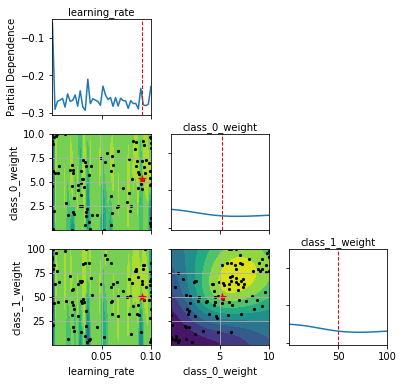

In [30]:
dim_names = [
    'learning_rate',
#     'past_history',
    'class_0_weight',
    'class_1_weight'
]

fig, ax = plot_objective(result=search_result, dimension_names=dim_names)

### Take the winning hyperparameters and conduct a long training run. This is our 'Cassandra' model. It represents the upper bound - how well can the output be modeled from the input?

In [31]:
space = search_result.space
winning_hyperparams = space.point_to_dict(search_result.x)
winning_hyperparams

{'learning_rate': 0.0906442687163723,
 'class_0_weight': 5.257255557070779,
 'class_1_weight': 49.76298099730598}

In [ ]:

{'learning_rate': 0.06761788678102645,
 'class_0_weight': 8.552362076028675,
 'class_1_weight': 87.16512996677713}

In [44]:
learning_rate = 0.06761788678102645
# past_history = winning_hyperparams['past_history']
class_0_weight = 8.552362076028675
class_1_weight = 87.16512996677713

class_weight = {0: class_0_weight, 1: class_1_weight}

EPOCHS = 350
batch_size = int((len(training_data) * 0.99) // past_history)
steps_per_epoch = int((len(training_data) * 0.99) // batch_size)
validation_steps = int((len(validation_data) * 0.99) // batch_size)

In [45]:
x_train, y_train = data_functions.multivariate_data(
    training_data, 
    training_labels, 
    0,
    None,
    past_history,
    future_target, 
    step
)

start_index = (x_train.shape[0] - (x_train.shape[0] % batch_size))
end_index = x_train.shape[0]
x_train = np.delete(x_train, range(start_index, end_index), axis=0)
y_train = np.delete(y_train, range(start_index, end_index), axis=0)

x_validation, y_validation = data_functions.multivariate_data(
    validation_data, 
    validation_labels, 
    0,
    None,
    past_history,
    future_target, 
    step
)

start_index = (x_validation.shape[0] - (x_validation.shape[0] % batch_size))
end_index = x_validation.shape[0]
x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)

x_test, y_test = data_functions.multivariate_data(
    test_data, 
    test_labels, 
    0,
    None,
    past_history,
    future_target, 
    step
)

start_index = (x_test.shape[0] - (x_test.shape[0] % batch_size))
end_index = x_test.shape[0]
x_testing = np.delete(x_test, range(start_index, end_index), axis=0)
y_testing = np.delete(y_test, range(start_index, end_index), axis=0)

input_dim = x_testing.shape[-2:]
input_shape = (batch_size, input_dim[0], input_dim[1])

In [46]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(
    100,
    batch_input_shape = input_shape,
    stateful = True
))

model.add(tf.keras.layers.Dense(
    1,
    activation = 'sigmoid',
    bias_initializer = output_bias)
)

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = metrics
)

In [47]:
log_dir = f'./LSTM_logs/single_statefull_optimization_round1/'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    x_train,
    y_train,
    epochs = EPOCHS,
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    #callbacks = [tensorboard_callback],
    validation_data = (x_validation, y_validation),
    validation_steps = validation_steps,
    class_weight = class_weight,
    workers = 8
    #verbose = 0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/350
3250/3250 [==============================] - 3s 890us/sample - loss: 17.5994 - true_positives: 57.0000 - false_positives: 453.0000 - true_negatives: 2524.0000 - false_negatives: 216.0000 - auc: 0.5490 - matthews_correlation: 0.0406 - val_loss: 11.3805 - val_true_positives: 114.0000 - val_false_positives: 991.0000 - val_true_negatives: 1999.0000 - val_false_negatives: 146.0000 - val_auc: 0.5812 - val_matthews_correlation: 0.0482
Epoch 2/350
3250/3250 [==============================] - 0s 24us/sample - loss: 9.3177 - true_positives: 189.0000 - false_positives: 999.0000 - true_negatives: 1978.0000 - false_negatives: 84.0000 - auc: 0.7275 - matthews_correlation: 0.2080 - val_loss: 10.3090 - val_true_positives: 251.0000 - val_false_positives: 1909.0000 - val_true_negatives: 1081.0000 - val_false_negatives: 9.0000 - val_auc: 0.7761 - val_matthews_correlation: 0.1819
Epoch 3/350
3250/

3250/3250 [==============================] - 0s 25us/sample - loss: 6.4062 - true_positives: 266.0000 - false_positives: 1100.0000 - true_negatives: 1877.0000 - false_negatives: 7.0000 - auc: 0.8515 - matthews_correlation: 0.3398 - val_loss: 8.3776 - val_true_positives: 235.0000 - val_false_positives: 1172.0000 - val_true_negatives: 1818.0000 - val_false_negatives: 25.0000 - val_auc: 0.7944 - val_matthews_correlation: 0.2767
Epoch 20/350
3250/3250 [==============================] - 0s 23us/sample - loss: 6.3720 - true_positives: 251.0000 - false_positives: 951.0000 - true_negatives: 2026.0000 - false_negatives: 22.0000 - auc: 0.8505 - matthews_correlation: 0.3451 - val_loss: 8.4626 - val_true_positives: 241.0000 - val_false_positives: 1363.0000 - val_true_negatives: 1627.0000 - val_false_negatives: 19.0000 - val_auc: 0.7942 - val_matthews_correlation: 0.2526
Epoch 21/350
3250/3250 [==============================] - 0s 24us/sample - loss: 6.3032 - true_positives: 262.0000 - false_positi

Epoch 38/350
3250/3250 [==============================] - 0s 24us/sample - loss: 5.0178 - true_positives: 253.0000 - false_positives: 661.0000 - true_negatives: 2316.0000 - false_negatives: 20.0000 - auc: 0.9179 - matthews_correlation: 0.4350 - val_loss: 9.5800 - val_true_positives: 232.0000 - val_false_positives: 1268.0000 - val_true_negatives: 1722.0000 - val_false_negatives: 28.0000 - val_auc: 0.7558 - val_matthews_correlation: 0.2518
Epoch 39/350
3250/3250 [==============================] - 0s 24us/sample - loss: 4.9215 - true_positives: 261.0000 - false_positives: 673.0000 - true_negatives: 2304.0000 - false_negatives: 12.0000 - auc: 0.9211 - matthews_correlation: 0.4503 - val_loss: 9.5731 - val_true_positives: 216.0000 - val_false_positives: 1070.0000 - val_true_negatives: 1920.0000 - val_false_negatives: 44.0000 - val_auc: 0.7608 - val_matthews_correlation: 0.2597
Epoch 40/350
3250/3250 [==============================] - 0s 23us/sample - loss: 5.0926 - true_positives: 255.0000 -

3250/3250 [==============================] - 0s 22us/sample - loss: 3.0516 - true_positives: 265.0000 - false_positives: 310.0000 - true_negatives: 2667.0000 - false_negatives: 8.0000 - auc: 0.9725 - matthews_correlation: 0.6303 - val_loss: 12.6153 - val_true_positives: 158.0000 - val_false_positives: 863.0000 - val_true_negatives: 2127.0000 - val_false_negatives: 102.0000 - val_auc: 0.7407 - val_matthews_correlation: 0.1901
Epoch 57/350
3250/3250 [==============================] - 0s 22us/sample - loss: 3.0342 - true_positives: 265.0000 - false_positives: 376.0000 - true_negatives: 2601.0000 - false_negatives: 8.0000 - auc: 0.9731 - matthews_correlation: 0.5895 - val_loss: 15.1872 - val_true_positives: 92.0000 - val_false_positives: 491.0000 - val_true_negatives: 2499.0000 - val_false_negatives: 168.0000 - val_auc: 0.7423 - val_matthews_correlation: 0.1362
Epoch 58/350
3250/3250 [==============================] - 0s 22us/sample - loss: 2.7199 - true_positives: 266.0000 - false_positiv

Epoch 75/350
3250/3250 [==============================] - 0s 24us/sample - loss: 1.6497 - true_positives: 269.0000 - false_positives: 167.0000 - true_negatives: 2810.0000 - false_negatives: 4.0000 - auc: 0.9925 - matthews_correlation: 0.7559 - val_loss: 18.1718 - val_true_positives: 102.0000 - val_false_positives: 635.0000 - val_true_negatives: 2355.0000 - val_false_negatives: 158.0000 - val_auc: 0.7103 - val_matthews_correlation: 0.1194
Epoch 76/350
3250/3250 [==============================] - 0s 22us/sample - loss: 1.5224 - true_positives: 271.0000 - false_positives: 157.0000 - true_negatives: 2820.0000 - false_negatives: 2.0000 - auc: 0.9936 - matthews_correlation: 0.7686 - val_loss: 19.2519 - val_true_positives: 118.0000 - val_false_positives: 618.0000 - val_true_negatives: 2372.0000 - val_false_negatives: 142.0000 - val_auc: 0.7176 - val_matthews_correlation: 0.1656
Epoch 77/350
3250/3250 [==============================] - 0s 22us/sample - loss: 1.5920 - true_positives: 268.0000 -

Epoch 94/350
3250/3250 [==============================] - 0s 23us/sample - loss: 0.6807 - true_positives: 271.0000 - false_positives: 51.0000 - true_negatives: 2926.0000 - false_negatives: 2.0000 - auc: 0.9990 - matthews_correlation: 0.9063 - val_loss: 25.0901 - val_true_positives: 85.0000 - val_false_positives: 463.0000 - val_true_negatives: 2527.0000 - val_false_negatives: 175.0000 - val_auc: 0.6860 - val_matthews_correlation: 0.1290
Epoch 95/350
3250/3250 [==============================] - 0s 22us/sample - loss: 0.6588 - true_positives: 271.0000 - false_positives: 51.0000 - true_negatives: 2926.0000 - false_negatives: 2.0000 - auc: 0.9989 - matthews_correlation: 0.9037 - val_loss: 25.4246 - val_true_positives: 86.0000 - val_false_positives: 492.0000 - val_true_negatives: 2498.0000 - val_false_negatives: 174.0000 - val_auc: 0.6836 - val_matthews_correlation: 0.1184
Epoch 96/350
3250/3250 [==============================] - 0s 21us/sample - loss: 0.9147 - true_positives: 271.0000 - fal

Epoch 113/350
3250/3250 [==============================] - 0s 24us/sample - loss: 1.2145 - true_positives: 267.0000 - false_positives: 102.0000 - true_negatives: 2875.0000 - false_negatives: 6.0000 - auc: 0.9950 - matthews_correlation: 0.8264 - val_loss: 25.2214 - val_true_positives: 82.0000 - val_false_positives: 479.0000 - val_true_negatives: 2511.0000 - val_false_negatives: 178.0000 - val_auc: 0.6887 - val_matthews_correlation: 0.1158
Epoch 114/350
3250/3250 [==============================] - 0s 23us/sample - loss: 1.2661 - true_positives: 263.0000 - false_positives: 103.0000 - true_negatives: 2874.0000 - false_negatives: 10.0000 - auc: 0.9954 - matthews_correlation: 0.8117 - val_loss: 24.0176 - val_true_positives: 100.0000 - val_false_positives: 550.0000 - val_true_negatives: 2440.0000 - val_false_negatives: 160.0000 - val_auc: 0.6972 - val_matthews_correlation: 0.1429
Epoch 115/350
3250/3250 [==============================] - 0s 23us/sample - loss: 1.4223 - true_positives: 267.000

Epoch 132/350
3250/3250 [==============================] - 0s 25us/sample - loss: 0.8208 - true_positives: 272.0000 - false_positives: 71.0000 - true_negatives: 2906.0000 - false_negatives: 1.0000 - auc: 0.9976 - matthews_correlation: 0.8771 - val_loss: 27.6350 - val_true_positives: 97.0000 - val_false_positives: 597.0000 - val_true_negatives: 2393.0000 - val_false_negatives: 163.0000 - val_auc: 0.6636 - val_matthews_correlation: 0.1200
Epoch 133/350
3250/3250 [==============================] - 0s 26us/sample - loss: 0.7320 - true_positives: 270.0000 - false_positives: 56.0000 - true_negatives: 2921.0000 - false_negatives: 3.0000 - auc: 0.9988 - matthews_correlation: 0.8927 - val_loss: 28.0958 - val_true_positives: 86.0000 - val_false_positives: 550.0000 - val_true_negatives: 2440.0000 - val_false_negatives: 174.0000 - val_auc: 0.6539 - val_matthews_correlation: 0.1080
Epoch 134/350
3250/3250 [==============================] - 0s 24us/sample - loss: 0.8060 - true_positives: 270.0000 - 

Epoch 151/350
3250/3250 [==============================] - 0s 22us/sample - loss: 0.7087 - true_positives: 271.0000 - false_positives: 83.0000 - true_negatives: 2894.0000 - false_negatives: 2.0000 - auc: 0.9989 - matthews_correlation: 0.8595 - val_loss: 33.5388 - val_true_positives: 56.0000 - val_false_positives: 389.0000 - val_true_negatives: 2601.0000 - val_false_negatives: 204.0000 - val_auc: 0.6456 - val_matthews_correlation: 0.0729
Epoch 152/350
3250/3250 [==============================] - 0s 21us/sample - loss: 0.6332 - true_positives: 270.0000 - false_positives: 48.0000 - true_negatives: 2929.0000 - false_negatives: 3.0000 - auc: 0.9990 - matthews_correlation: 0.9076 - val_loss: 31.0263 - val_true_positives: 69.0000 - val_false_positives: 408.0000 - val_true_negatives: 2582.0000 - val_false_negatives: 191.0000 - val_auc: 0.6604 - val_matthews_correlation: 0.1023
Epoch 153/350
3250/3250 [==============================] - 0s 22us/sample - loss: 0.5687 - true_positives: 272.0000 - 

Epoch 170/350
3250/3250 [==============================] - 0s 23us/sample - loss: 0.5366 - true_positives: 272.0000 - false_positives: 29.0000 - true_negatives: 2948.0000 - false_negatives: 1.0000 - auc: 0.9973 - matthews_correlation: 0.9438 - val_loss: 32.7427 - val_true_positives: 77.0000 - val_false_positives: 461.0000 - val_true_negatives: 2529.0000 - val_false_negatives: 183.0000 - val_auc: 0.6588 - val_matthews_correlation: 0.1076
Epoch 171/350
3250/3250 [==============================] - 0s 23us/sample - loss: 0.4583 - true_positives: 271.0000 - false_positives: 40.0000 - true_negatives: 2937.0000 - false_negatives: 2.0000 - auc: 0.9991 - matthews_correlation: 0.9240 - val_loss: 33.3281 - val_true_positives: 75.0000 - val_false_positives: 451.0000 - val_true_negatives: 2539.0000 - val_false_negatives: 185.0000 - val_auc: 0.6534 - val_matthews_correlation: 0.1063
Epoch 172/350
3250/3250 [==============================] - 0s 24us/sample - loss: 0.3442 - true_positives: 271.0000 - 

3250/3250 [==============================] - 0s 23us/sample - loss: 0.3983 - true_positives: 273.0000 - false_positives: 24.0000 - true_negatives: 2953.0000 - false_negatives: 0.0000e+00 - auc: 0.9988 - matthews_correlation: 0.9560 - val_loss: 40.3849 - val_true_positives: 50.0000 - val_false_positives: 318.0000 - val_true_negatives: 2672.0000 - val_false_negatives: 210.0000 - val_auc: 0.6170 - val_matthews_correlation: 0.0727
Epoch 189/350
3250/3250 [==============================] - 0s 23us/sample - loss: 0.4880 - true_positives: 270.0000 - false_positives: 17.0000 - true_negatives: 2960.0000 - false_negatives: 3.0000 - auc: 0.9993 - matthews_correlation: 0.9616 - val_loss: 33.1184 - val_true_positives: 81.0000 - val_false_positives: 432.0000 - val_true_negatives: 2558.0000 - val_false_negatives: 179.0000 - val_auc: 0.6616 - val_matthews_correlation: 0.1276
Epoch 190/350
3250/3250 [==============================] - 0s 23us/sample - loss: 0.4652 - true_positives: 272.0000 - false_posi

Epoch 207/350
3250/3250 [==============================] - 0s 25us/sample - loss: 1.2869 - true_positives: 268.0000 - false_positives: 125.0000 - true_negatives: 2852.0000 - false_negatives: 5.0000 - auc: 0.9939 - matthews_correlation: 0.8006 - val_loss: 32.5503 - val_true_positives: 94.0000 - val_false_positives: 527.0000 - val_true_negatives: 2463.0000 - val_false_negatives: 166.0000 - val_auc: 0.6579 - val_matthews_correlation: 0.1310
Epoch 208/350
3250/3250 [==============================] - 0s 23us/sample - loss: 1.1239 - true_positives: 265.0000 - false_positives: 62.0000 - true_negatives: 2915.0000 - false_negatives: 8.0000 - auc: 0.9954 - matthews_correlation: 0.8763 - val_loss: 36.9892 - val_true_positives: 74.0000 - val_false_positives: 438.0000 - val_true_negatives: 2552.0000 - val_false_negatives: 186.0000 - val_auc: 0.6448 - val_matthews_correlation: 0.1067
Epoch 209/350
3250/3250 [==============================] - 0s 24us/sample - loss: 0.8375 - true_positives: 270.0000 -

Epoch 226/350
3250/3250 [==============================] - 0s 28us/sample - loss: 0.9656 - true_positives: 268.0000 - false_positives: 59.0000 - true_negatives: 2918.0000 - false_negatives: 5.0000 - auc: 0.9961 - matthews_correlation: 0.8865 - val_loss: 31.6944 - val_true_positives: 86.0000 - val_false_positives: 493.0000 - val_true_negatives: 2497.0000 - val_false_negatives: 174.0000 - val_auc: 0.6667 - val_matthews_correlation: 0.1219
Epoch 227/350
3250/3250 [==============================] - 0s 26us/sample - loss: 0.6172 - true_positives: 272.0000 - false_positives: 67.0000 - true_negatives: 2910.0000 - false_negatives: 1.0000 - auc: 0.9991 - matthews_correlation: 0.8807 - val_loss: 31.0338 - val_true_positives: 85.0000 - val_false_positives: 489.0000 - val_true_negatives: 2501.0000 - val_false_negatives: 175.0000 - val_auc: 0.6662 - val_matthews_correlation: 0.1200
Epoch 228/350
3250/3250 [==============================] - 0s 27us/sample - loss: 0.6029 - true_positives: 272.0000 - 

3250/3250 [==============================] - 0s 23us/sample - loss: 0.2274 - true_positives: 272.0000 - false_positives: 15.0000 - true_negatives: 2962.0000 - false_negatives: 1.0000 - auc: 0.9997 - matthews_correlation: 0.9683 - val_loss: 38.7174 - val_true_positives: 71.0000 - val_false_positives: 394.0000 - val_true_negatives: 2596.0000 - val_false_negatives: 189.0000 - val_auc: 0.6445 - val_matthews_correlation: 0.1176
Epoch 245/350
3250/3250 [==============================] - 0s 23us/sample - loss: 0.2512 - true_positives: 273.0000 - false_positives: 21.0000 - true_negatives: 2956.0000 - false_negatives: 0.0000e+00 - auc: 0.9996 - matthews_correlation: 0.9620 - val_loss: 38.2883 - val_true_positives: 74.0000 - val_false_positives: 417.0000 - val_true_negatives: 2573.0000 - val_false_negatives: 186.0000 - val_auc: 0.6454 - val_matthews_correlation: 0.1154
Epoch 246/350
3250/3250 [==============================] - 0s 22us/sample - loss: 0.3655 - true_positives: 271.0000 - false_posi

Epoch 263/350
3250/3250 [==============================] - 0s 24us/sample - loss: 0.2524 - true_positives: 273.0000 - false_positives: 22.0000 - true_negatives: 2955.0000 - false_negatives: 0.0000e+00 - auc: 0.9997 - matthews_correlation: 0.9598 - val_loss: 41.1077 - val_true_positives: 74.0000 - val_false_positives: 387.0000 - val_true_negatives: 2603.0000 - val_false_negatives: 186.0000 - val_auc: 0.6307 - val_matthews_correlation: 0.1269
Epoch 264/350
3250/3250 [==============================] - 0s 24us/sample - loss: 0.2832 - true_positives: 272.0000 - false_positives: 9.0000 - true_negatives: 2968.0000 - false_negatives: 1.0000 - auc: 0.9998 - matthews_correlation: 0.9805 - val_loss: 40.1113 - val_true_positives: 72.0000 - val_false_positives: 425.0000 - val_true_negatives: 2565.0000 - val_false_negatives: 188.0000 - val_auc: 0.6281 - val_matthews_correlation: 0.1093
Epoch 265/350
3250/3250 [==============================] - 0s 24us/sample - loss: 0.2282 - true_positives: 273.0000

3250/3250 [==============================] - 0s 22us/sample - loss: 0.0961 - true_positives: 273.0000 - false_positives: 2.0000 - true_negatives: 2975.0000 - false_negatives: 0.0000e+00 - auc: 1.0000 - matthews_correlation: 0.9967 - val_loss: 44.5304 - val_true_positives: 70.0000 - val_false_positives: 374.0000 - val_true_negatives: 2616.0000 - val_false_negatives: 190.0000 - val_auc: 0.6315 - val_matthews_correlation: 0.1216
Epoch 282/350
3250/3250 [==============================] - 0s 23us/sample - loss: 0.0761 - true_positives: 273.0000 - false_positives: 5.0000 - true_negatives: 2972.0000 - false_negatives: 0.0000e+00 - auc: 1.0000 - matthews_correlation: 0.9905 - val_loss: 43.4503 - val_true_positives: 78.0000 - val_false_positives: 396.0000 - val_true_negatives: 2594.0000 - val_false_negatives: 182.0000 - val_auc: 0.6479 - val_matthews_correlation: 0.1355
Epoch 283/350
3250/3250 [==============================] - 0s 25us/sample - loss: 0.1018 - true_positives: 273.0000 - false_po

3250/3250 [==============================] - 0s 24us/sample - loss: 0.2054 - true_positives: 272.0000 - false_positives: 9.0000 - true_negatives: 2968.0000 - false_negatives: 1.0000 - auc: 0.9998 - matthews_correlation: 0.9802 - val_loss: 43.5803 - val_true_positives: 75.0000 - val_false_positives: 373.0000 - val_true_negatives: 2617.0000 - val_false_negatives: 185.0000 - val_auc: 0.6258 - val_matthews_correlation: 0.1386
Epoch 300/350
3250/3250 [==============================] - 0s 24us/sample - loss: 0.2716 - true_positives: 271.0000 - false_positives: 17.0000 - true_negatives: 2960.0000 - false_negatives: 2.0000 - auc: 0.9998 - matthews_correlation: 0.9633 - val_loss: 41.6664 - val_true_positives: 81.0000 - val_false_positives: 443.0000 - val_true_negatives: 2547.0000 - val_false_negatives: 179.0000 - val_auc: 0.6264 - val_matthews_correlation: 0.1294
Epoch 301/350
3250/3250 [==============================] - 0s 24us/sample - loss: 0.2521 - true_positives: 272.0000 - false_positives

Epoch 318/350
3250/3250 [==============================] - 0s 24us/sample - loss: 0.1383 - true_positives: 273.0000 - false_positives: 11.0000 - true_negatives: 2966.0000 - false_negatives: 0.0000e+00 - auc: 1.0000 - matthews_correlation: 0.9789 - val_loss: 47.9378 - val_true_positives: 62.0000 - val_false_positives: 355.0000 - val_true_negatives: 2635.0000 - val_false_negatives: 198.0000 - val_auc: 0.6139 - val_matthews_correlation: 0.1092
Epoch 319/350
3250/3250 [==============================] - 0s 23us/sample - loss: 0.1964 - true_positives: 273.0000 - false_positives: 19.0000 - true_negatives: 2958.0000 - false_negatives: 0.0000e+00 - auc: 0.9999 - matthews_correlation: 0.9661 - val_loss: 47.6452 - val_true_positives: 61.0000 - val_false_positives: 342.0000 - val_true_negatives: 2648.0000 - val_false_negatives: 199.0000 - val_auc: 0.6221 - val_matthews_correlation: 0.1093
Epoch 320/350
3250/3250 [==============================] - 0s 23us/sample - loss: 0.2542 - true_positives: 272

Epoch 337/350
3250/3250 [==============================] - 0s 26us/sample - loss: 0.6968 - true_positives: 270.0000 - false_positives: 56.0000 - true_negatives: 2921.0000 - false_negatives: 3.0000 - auc: 0.9980 - matthews_correlation: 0.8958 - val_loss: 39.6266 - val_true_positives: 88.0000 - val_false_positives: 516.0000 - val_true_negatives: 2474.0000 - val_false_negatives: 172.0000 - val_auc: 0.6253 - val_matthews_correlation: 0.1214
Epoch 338/350
3250/3250 [==============================] - 0s 23us/sample - loss: 0.9983 - true_positives: 270.0000 - false_positives: 71.0000 - true_negatives: 2906.0000 - false_negatives: 3.0000 - auc: 0.9963 - matthews_correlation: 0.8763 - val_loss: 42.7102 - val_true_positives: 67.0000 - val_false_positives: 427.0000 - val_true_negatives: 2563.0000 - val_false_negatives: 193.0000 - val_auc: 0.6082 - val_matthews_correlation: 0.0959
Epoch 339/350
3250/3250 [==============================] - 0s 24us/sample - loss: 0.5295 - true_positives: 270.0000 - 

Total observations: 3287


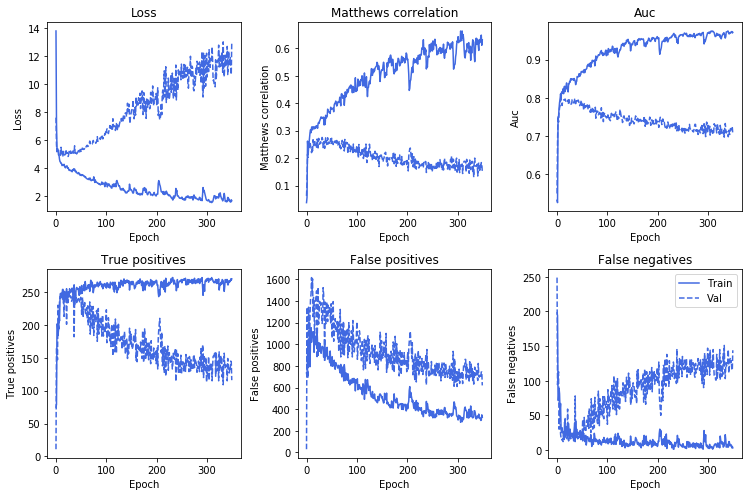

In [37]:
metric_names =  ['loss', 'matthews_correlation', 'auc', 'true_positives', 'false_positives', 'false_negatives']
filename = '../project_info/figures/single_LSTM_learning_curves_CA_only.png'
print(f"Total observations: {len(training_data)}")
plotting_functions.plot_metrics(history, metric_names, filename)

In [38]:
train_predictions = model.predict(x_train)
validation_predictions = model.predict(x_validation)
test_predictions = model.predict(x_testing)

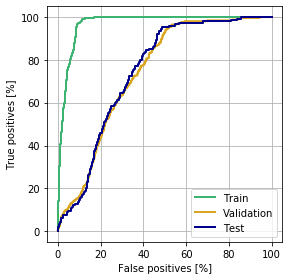

In [39]:
plotting_functions.plot_roc("Train", y_train, train_predictions, color='mediumseagreen')
plotting_functions.plot_roc("Validation", y_validation, validation_predictions, color='goldenrod')
plotting_functions.plot_roc("Test", y_testing, test_predictions, color='darkblue')
plt.legend(loc='lower right')
plt.show()

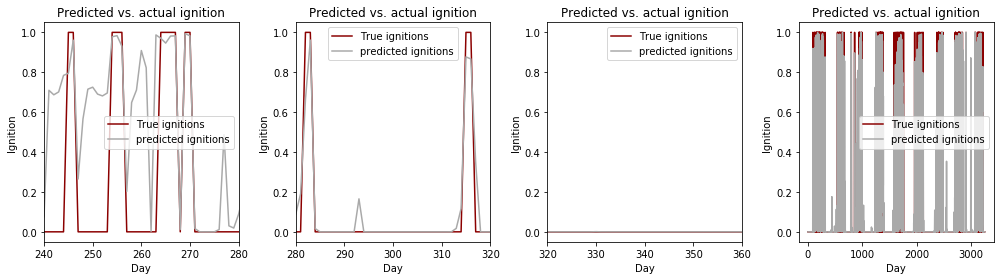

In [40]:
filename = '../project_info/figures/single_statefull_LSTM_training_predictions_CA_only.png'
plotting_functions.plot_ignition_predictions(train_predictions, y_train, filename)

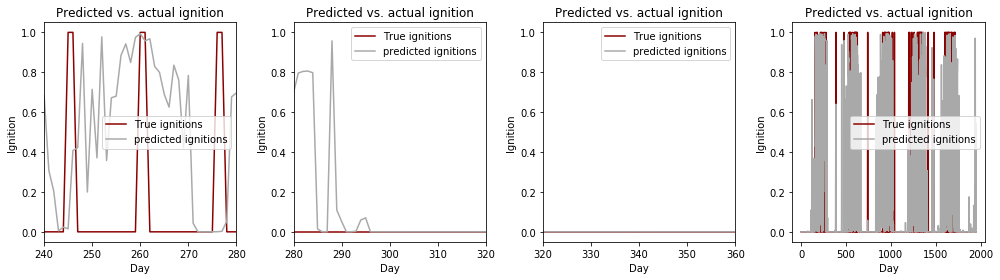

In [41]:
filename = '../project_info/figures/single_statefull_LSTM_testing_predictions_CA_only.png'
plotting_functions.plot_ignition_predictions(test_predictions, y_testing, filename)

loss :  0.193686144053936
true_positives :  264.0
false_positives :  286.0
true_negatives :  2691.0
false_negatives :  9.0
auc :  0.9695942
matthews_correlation :  0.6408064
No fire (True Negatives):  2692
False alarms (False Positives):  285
Fires missed (False Negatives):  8
Fires detected (True Positives):  265
Total fires:  273


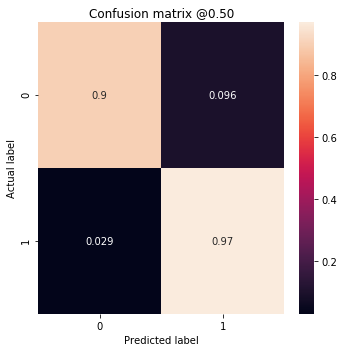

In [42]:
results = model.evaluate(
    x_train,
    y_train, 
    verbose=0
)

for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)

plotting_functions.plot_cm(y_train, train_predictions)

### Sucess - we have achieved 100% accuracy on the training data. This means that the code is working and the problem is tractable. The challenge now is the regularize the model so that it will generalize.

loss :  0.5908719102541605
true_positives :  64.0
false_positives :  344.0
true_negatives :  1457.0
false_negatives :  85.0
auc :  0.7044874
matthews_correlation :  0.15172857
No fire (True Negatives):  1458
False alarms (False Positives):  343
Fires missed (False Negatives):  85
Fires detected (True Positives):  64
Total fires:  149


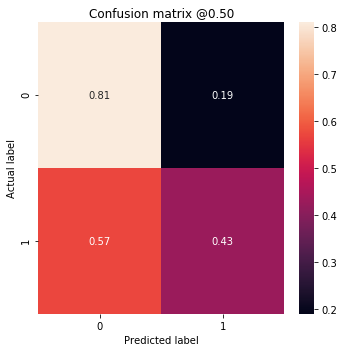

In [43]:
results = model.evaluate(
    x_testing,
    y_testing, 
    verbose=0
)

for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)

plotting_functions.plot_cm(y_testing, test_predictions)

### To improve generalizability we will run a second Gaussian process minimization.
1. Number of LSTM units will be added as a tunable parameter
2. Variational dropout will be added to the LSTM units as a tunable parameter
3. Gaussian optimization and early stopping will use Matthews correlation on the validation set rather than the training set

In [ ]:
future_target = 1
step = 1
past_history = 5
lstm_units = 1

raw_output_bias = np.log([num_fires/(total_observations - num_fires)])
output_bias = tf.keras.initializers.Constant(raw_output_bias)

EPOCHS = 50

path_best_model = '../../trained_models/best_skopt_single_statefull_LTSM_CA_only.keras'
best_val_matthews_correlation = -1.0

metrics = [
    keras.metrics.TruePositives(name = 'true_positives'),
    keras.metrics.FalsePositives(name = 'false_positives'),
    keras.metrics.TrueNegatives(name = 'true_negatives'),
    keras.metrics.FalseNegatives(name = 'false_negatives'), 
    keras.metrics.AUC(name = 'auc'),
    data_functions.matthews_correlation
]

dim_learning_rate = Real(
    low = 0.0001,
    high = 0.1, 
    name = 'learning_rate'
)

# dim_past_history = Integer(
#     low = 1,
#     high = 5, 
#     name = 'past_history'
# )

dim_class_0_weight = Real(
    low = 0.001, 
    high = 20,
    name = 'class_0_weight'
)

dim_class_1_weight = Real(
    low = 0.01, 
    high = 100,
    name = 'class_1_weight'
)

# dim_lstm_units = Integer(
#     low=1, 
#     high=5,
#     name='lstm_units'
# )

dim_variational_dropout = Real(
    low=0.01, 
    high=0.5,
    name='variational_dropout'
)

dim_recurrent_dropout = Real(
    low=0.01, 
    high=0.5,
    name='recurrent_dropout'
)

default_parameters = [learning_rate, class_0_weight, class_1_weight, 0.1, 0.1]
#default_parameters = [50, 0.1]

dimensions = [
    dim_learning_rate,
#     dim_past_history, 
    dim_class_0_weight, 
    dim_class_1_weight,
#     dim_lstm_units,
    dim_variational_dropout,
    dim_recurrent_dropout
]

# Use early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_matthews_correlation', 
    #verbose = 0,
    patience = 5,
    mode = 'max',
    restore_best_weights = True
)

run_num = 1

In [ ]:
def make_model(
        input_shape,
        learning_rate,
        lstm_units,
        variational_dropout,
        recurrent_dropout
):    
    
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.LSTM(
        lstm_units,
        batch_input_shape = input_shape,
        dropout = variational_dropout,
        recurrent_dropout = recurrent_dropout,
        stateful = True
    ))
    
    model.add(tf.keras.layers.Dense(
        1,
        activation = 'sigmoid',
        bias_initializer = output_bias)
    )

    model.compile(
        optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
        loss = keras.losses.BinaryCrossentropy(),
        metrics = metrics
    )

    return model

@use_named_args(dimensions=dimensions)
def fitness(
#     past_history,
    learning_rate,
    class_0_weight,
    class_1_weight,
#     lstm_units,
    variational_dropout,
    recurrent_dropout
):

    # Print the hyper-parameters.
#     print('past history:', past_history)
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('class 0 weight: {0:.1e}'.format(class_0_weight))
    print('class 1 weight: {0:.1e}'.format(class_1_weight))
#     print('lstm units:', lstm_units)
    print('variational droput: {0:.1e}'.format(variational_dropout))
    print('recurrent dropout: {0:.1e}'.format(recurrent_dropout))
    print()
    
    batch_size = int((len(training_data) * 0.99) // past_history)
    steps_per_epoch = int((len(training_data) * 0.99) // batch_size)
    validation_steps = int((len(validation_data) * 0.99) // batch_size)
    
    # create data stream
    x_train, y_train = data_functions.multivariate_data(
        training_data, 
        training_labels, 
        0,
        None,
        past_history,
        future_target, 
        step
    )
    
    x_validation, y_validation = data_functions.multivariate_data(
        validation_data, 
        validation_labels, 
        0,
        None,
        past_history,
        future_target, 
        step
    )
    
    start_index = (x_train.shape[0] - (x_train.shape[0] % batch_size))
    end_index = x_train.shape[0]
    
    x_train = np.delete(x_train, range(start_index, end_index), axis=0)
    y_train = np.delete(y_train, range(start_index, end_index), axis=0)
    
    start_index = (x_validation.shape[0] - (x_validation.shape[0] % batch_size))
    end_index = x_validation.shape[0]
    
    x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
    y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)
    
    input_dim = x_train.shape[-2:]
    input_shape = (batch_size, input_dim[0], input_dim[1])
    
    # Create the neural network with these hyper-parameters.
    model = make_model(
        input_shape = input_shape,
        learning_rate = learning_rate,
        lstm_units = lstm_units,
        variational_dropout = variational_dropout,
        recurrent_dropout = recurrent_dropout
    )
    
    model.summary()
    print()
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    global run_num
    
    log_dir = f'./LSTM_logs/single_statefull_gp_min_run{run_num}/'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
   
    # Use Keras to train the model.
    history = model.fit(
        x_train,
        y_train,
        epochs = EPOCHS,
        batch_size = batch_size,
        steps_per_epoch = steps_per_epoch,
        callbacks = [early_stopping_callback],
        validation_data = (x_validation, y_validation),
        validation_steps = validation_steps,
        class_weight = class_weight,
        workers = 8
        #verbose=0
    )

    val_matthews_correlation = history.history['val_matthews_correlation'][-1]
    
    print()
    print()
    print(f"Run {run_num} final validation matthews correlation: {val_matthews_correlation}")
    print()
    
    run_num += 1

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_val_matthews_correlation

    # If the classification accuracy of the saved model is improved ...
    if val_matthews_correlation > best_val_matthews_correlation:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_val_matthews_correlation = val_matthews_correlation
        
    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -val_matthews_correlation

In [ ]:
%%time

search_result = gp_minimize(
    func = fitness,
    dimensions = dimensions,
    acq_func = 'EI', # Expected Improvement.
    n_calls = 200,
    x0 = default_parameters
)

In [ ]:
dim_names = [
#     'past_history',
    'learning_rate',
    'class_0_weight',
    'class_1_weight',
#     'lstm_units',
    'variational_dropout',
    'recurrent_dropout'
]

fig, ax = plot_objective(result = search_result, dimension_names = dim_names)

In [ ]:
space = search_result.space
winning_hyperparams = space.point_to_dict(search_result.x)
winning_hyperparams

In [ ]:
# hyperparameters
#learning_rate = winning_hyperparams['learning_rate']
learning_rate = 0.07
# past_history = winning_hyperparams['past_history']
class_0_weight = winning_hyperparams['class_0_weight']
class_1_weight = winning_hyperparams['class_1_weight']
#lstm_units = winning_hyperparams['lstm_units']
#variational_dropout = winning_hyperparams['variational_dropout']
variational_dropout = 0.1
recurrent_dropout = winning_hyperparams['recurrent_dropout']
recurrent_dropout = 0.5
# learning_rate = 0.05
# past_history = 9
# class_0_weight = 4
# class_1_weight = 25
# lstm_units = 1
# variational_dropout = 0.48
# recurrent_dropout = 0.5

EPOCHS = 200
batch_size = int((len(training_data) * 0.99) // past_history)
steps_per_epoch = int((len(training_data) * 0.99) // batch_size)
validation_steps = int((len(validation_data) * 0.99) // batch_size)

In [ ]:
x_train, y_train = data_functions.multivariate_data(
    training_data, 
    training_labels, 
    0,
    None,
    past_history,
    future_target, 
    step
)

start_index = (x_train.shape[0] - (x_train.shape[0] % batch_size))
end_index = x_train.shape[0]
x_train = np.delete(x_train, range(start_index, end_index), axis=0)
y_train = np.delete(y_train, range(start_index, end_index), axis=0)

x_validation, y_validation = data_functions.multivariate_data(
    validation_data, 
    validation_labels, 
    0,
    None,
    past_history,
    future_target, 
    step
)

start_index = (x_validation.shape[0] - (x_validation.shape[0] % batch_size))
end_index = x_validation.shape[0]
x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)

x_test, y_test = data_functions.multivariate_data(
    test_data, 
    test_labels, 
    0,
    None,
    past_history,
    future_target, 
    step
)

start_index = (x_test.shape[0] - (x_test.shape[0] % batch_size))
end_index = x_test.shape[0]
x_testing = np.delete(x_test, range(start_index, end_index), axis=0)
y_testing = np.delete(y_test, range(start_index, end_index), axis=0)

input_dim = x_testing.shape[-2:]
input_shape = (batch_size, input_dim[0], input_dim[1])

In [ ]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(
    1,
    batch_input_shape = input_shape,
    dropout = variational_dropout,
    recurrent_dropout = recurrent_dropout,
    stateful = True
))

model.add(tf.keras.layers.Dense(
    1,
    activation = 'sigmoid',
    bias_initializer = output_bias)
)

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = metrics
)

In [ ]:
model.summary()

In [ ]:
history = model.fit(
    x_train,
    y_train,
    epochs = EPOCHS,
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    #callbacks = [early_stopping_callback],
    validation_data = (x_validation, y_validation),
    validation_steps = validation_steps,
    class_weight = class_weight,
    workers = 8
    #verbose=0
)

In [ ]:
metric_names =  ['loss', 'matthews_correlation', 'auc', 'true_positives', 'false_positives', 'false_negatives']
filename = '../../figures/single_LSTM_learning_curves_CA_only.png'
print(f"Total observations: {len(training_data)}")
plotting_functions.plot_metrics(history, metric_names, filename)

In [ ]:
train_predictions = model.predict(x_train)
validation_predictions = model.predict(x_validation)
test_predictions = model.predict(x_testing)

In [ ]:
plotting_functions.plot_roc("Train", y_train, train_predictions, color='darkgray')
plotting_functions.plot_roc("Validation", y_validation, validation_predictions, color='goldenrod')
plotting_functions.plot_roc("Test", y_testing, test_predictions, color='darkblue')
plt.legend(loc='lower right')
plt.show()

In [ ]:
filename = '../../figures/single_statefull_LSTM_training_predictions_CA_only.png'
plotting_functions.plot_ignition_predictions(train_predictions, y_train, filename)

In [ ]:
filename = '../../figures/single_statefull_LSTM_testing_predictions_CA_only.png'
plotting_functions.plot_ignition_predictions(test_predictions, y_testing, filename)

In [ ]:
results = model.evaluate(
    x_train,
    y_train, 
    verbose=0
)

for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)

plotting_functions.plot_cm(y_train, train_predictions)

In [ ]:
results = model.evaluate(
    x_testing,
    y_testing, 
    verbose=0
)

for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)

plotting_functions.plot_cm(y_testing, test_predictions)